### ***1. Library import***

In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import random
import pickle
from google.cloud import bigquery
import math
import re
#!pip install xgboost
import xgboost as xgb
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from itertools import combinations 
import time
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt 
import seaborn as sns
#!pip install gensim
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer 
client = bigquery.Client()
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
import numpy as np

project = 'namshi-datahut' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ***2. Flow of the Notebook***

Run iteration specification: 
* Relevance: based on CTR

Level of the data and timeframe 
* The data is imported at 'imp_path', 'sku' , 'imp_position' level. Total clicks and Total impression are the two measures imported
* Two weeks of training data is considered, using two folds for two weeks
* The timeframe of the trainig data is fold1 = (current_date-14 to current_date-8) , fold2 = (current_date-15 to current_date-21) and current_date-7 to current_date-1 will be used for testing


Filters applied
* A cumulative distribution of clicks is calculated at sku level
* Top 90% of click contributing skus are consider to eliminate the outliers 
* A product must have atleast 30 impression to make it to the final training


Features for the model
* product attributes such as:
    * Brand, category, department, gender, subcategory, color etc.
    * Time since launch and time since relaunch
    * Discount percentage, average product availability etc.
    * The numeric measures are categorized also
* Historical product performance:
    * fold1 = (current_date-21 to current_date-15), fold2 = (current_date-22 to current_date-28)
    * CTR
    * Computing the CTR at different levels: Brand,Query-Brand, Category,Query-Category, etc.
    * Computing CTR at combination of levels: Brand-Category-Gender, Brand-Subcategory-gender etc.
    * Upto 3 levels of combinations are calculated

### ***3. Data Cleaning***

#### Click model

In [3]:
def click_model(df_ip,num_pos=[5,10,15], model = 'lr'):
    '''
    Objective:
    * A click model is used for obtaining a relationship between impressions at different imp_positions and total click
    * The predicted clicks from the model used in conjunction with actual clicks to obtain a relevancy score
    * Relevance score = CEIL(4 * (actual clicks/predicted clicks))
    
    Input parameters:
    df_ip: Input dataframe
    num_pos: positions upto which the imp_postions to be considered while building click model
    model: type of model  - 'lr' = linear regression, 'rf' = random forest
    
    Output:
    * A dataframe containing the accuracy results for each of num_pos
    * Output dataframe containing the predicted clicks
    
    '''
    
    
    #df_results = pd.DataFrame(columns=['imp_positions','train_rmse','test_rmse','train_r2','test_r2','train_MAPE','test_MAPE'])
    df_results = pd.DataFrame(columns=['imp_positions','train_rmse','train_r2','train_MAPE'])
    
    for i in num_pos:
        result = []
        df = df_ip[df_ip['imp_position']<=i]
        df.reset_index(drop=True,inplace=True)
        df[['imp_position','total_impressions','total_clicks']] = df[['imp_position','total_impressions','total_clicks']].astype(int)
        df_pivot = df.pivot_table(index=['imp_path','sku'],values = 'total_impressions', columns= 'imp_position' ).fillna(0).reset_index()
        click_by_item_pos = df.groupby(['imp_path','sku'],as_index=False)['total_clicks'].sum()
        df_pivot = df_pivot.merge(click_by_item_pos, on = ['imp_path','sku'],how='left')
        df_pivot.sort_values(['imp_path','total_clicks'], ascending=[True,False],inplace=True)

        df_pivot.reset_index(drop = True, inplace=True)
        df_train = df_pivot[df_pivot.columns[2:]]
        #print('check1')
        

        x = df.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        for col in df_train.columns:
            x_scaled = min_max_scaler.fit_transform(df_train[col].values.reshape(-1,1))
            df_train[col] = x_scaled

        #print('check2')

        # separate the independent and target variable 
        train_X = df_train.drop(columns=['total_clicks'],axis=1)
        train_Y = df_train['total_clicks']
        
        #for testing
        #train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.25,random_state=0)    
        
        # create an object of the LinearRegression Model
        if model == 'lr':
            #print('check3')
            click_model = LinearRegression()

        # fit the model with the training data
            click_model.fit(train_X, train_Y)

        # predict the target on train and test data
         
            predict_train = click_model.predict(train_X)
            #predict_test  = click_model.predict(test_x)
            print('check4')
            
        elif model== 'rf':
            click_model = RandomForestRegressor(n_estimators=200, max_depth=10)
            # fit the model with the training data
            click_model.fit(train_X, train_Y)
            # predict the target on train and test data 
            
            predict_train = click_model.predict(train_X)
            #predict_test  = click_model.predict(test_x)
            
        
        result.append(i)
        result.append(mean_squared_error(train_Y, predict_train)**(0.5))
        #result.append(mean_squared_error(test_y, predict_test)**(0.5))
        result.append(r2_score(train_Y, predict_train))
        #result.append(r2_score(test_y, predict_test))
        result.append(MAPE(train_Y,predict_train))
        #result.append(MAPE(test_y,predict_test))
        df_results.loc[len(df_results)] = result
    #print('check5')
    relevance_df = pd.concat([df_pivot,pd.DataFrame(predict_train,columns=['predicted'])],axis=1)
    #print('check6')
    return click_model,df_results,relevance_df,train_X

def MAPE(y_act,y_pred):
    y_act = np.array(y_act)
    y_pred = np.array(y_pred)
    acc = []
    for i in range(len(y_act)):
        if (y_act[i] !=0):
            acc.append(np.round((abs(y_act[i]-y_pred[i])/y_act[i])*100))
    return np.round(((sum(acc)/len(acc))/100),2)


def click_model_scoring(df_ip,model,num_pos=45):
    '''
    Objective:
    * Click model for scoring
    
    Input parameters:
    df_ip: Input dataframe
    num_pos: positions upto which the imp_postions to be considered while building click model
    model: trained click model
    
    Output:
    * Output dataframe containing the predicted clicks
    
    '''
    
    df = df_ip[df_ip['imp_position']<=num_pos]
    df.reset_index(drop=True,inplace=True)
    df_pivot = df.pivot_table(index=['imp_path','sku'],values = 'total_impressions', columns= 'imp_position' ).fillna(0).reset_index()
    click_by_item_pos = df.groupby(['imp_path','sku'],as_index=False)['total_clicks'].sum()
    df_pivot = df_pivot.merge(click_by_item_pos, on = ['imp_path','sku'],how='left')
    df_pivot.sort_values(['imp_path','total_clicks'], ascending=[True,False],inplace=True)

    df_pivot.reset_index(drop = True, inplace=True)
    df_test = df_pivot[df_pivot.columns[2:]]

    # separate the independent and target variable 
    test_X = df_test.drop(columns=['total_clicks'],axis=1)
    test_Y = df_test['total_clicks']

    predict_test  = model.predict(test_X)

    return pd.concat([df_pivot,pd.DataFrame(predict_test,columns=['predicted'])],axis=1) 

#### Sorting click model output

In [4]:
def sort_and_process_relevance_data(relevance_df,pos=50):
    
    '''
    objective: 
    Process the output of click model so that it is ready to be joined with feature set
    
    Input parameters:
    Output of click model
    
    Output:
    Processed dataframe
    '''
    min_max_scaler = preprocessing.MinMaxScaler()
    
    relevance_df['total_clcks_normalized'] = min_max_scaler.fit_transform(relevance_df['total_clicks'].values.reshape(-1,1))
    relevance_df['ratio'] = np.round((relevance_df['total_clcks_normalized']/relevance_df['predicted']),3)
    #Sorting the output df based on query and ratio
    relevance_df['total_imps'] = relevance_df.iloc[:,2:pos+2].sum(axis=1)
    if pos>=10:
        relevance_df['total_imps_1_10'] = relevance_df.iloc[:,2:11].sum(axis=1)
    else:
        relevance_df['total_imps_1_10'] = 0
    
    if pos>=20:
        relevance_df['total_imps_10_20'] = relevance_df.iloc[:,11:21].sum(axis=1)
    else:
        relevance_df['total_imps_10_20'] = 0
        
    if pos>=30:
        relevance_df['total_imps_20_30'] = relevance_df.iloc[:,21:31].sum(axis=1)
    else:
        relevance_df['total_imps_20_30'] = 0
        
    if pos>=40:
        relevance_df['total_imps_30_40'] = relevance_df.iloc[:,31:41].sum(axis=1)
    else:
        relevance_df['total_imps_30_40'] = 0
        
    if pos==50:
        relevance_df['total_imps_40_50'] = relevance_df.iloc[:,41:50].sum(axis=1)
    else:
        relevance_df['total_imps_40_50'] = 0 
        
    relevance_df = relevance_df.sort_values(['imp_path','ratio'],ascending=[True,False])[['imp_path','sku','total_clicks','total_imps','total_imps_1_10',
                                                                                          'total_imps_10_20','total_imps_20_30','total_imps_30_40','total_imps_40_50','predicted','ratio']]
    
    OL_detection = relevance_df.groupby(['imp_path'],as_index=False)['ratio'].quantile(0.95).rename({'ratio':'quantile_95_ratio'},axis=1)
    relevance_df = relevance_df.merge(OL_detection,on='imp_path',how='left')
    relevance_df = relevance_df[relevance_df['ratio']<=relevance_df['quantile_95_ratio']]
    relevance_df.reset_index(drop=True,inplace=True)
    temp = relevance_df.groupby(['imp_path'],as_index=False)['ratio'].max().rename({'ratio':'max_ratio'},axis=1)
    relevance_df = relevance_df.merge(temp,on=['imp_path'])
    #relevance_df['relevance_score'] = np.ceil(5*(relevance_df['ratio']/relevance_df['max_ratio']))

    relevance_df['click_through_Rate'] = np.where(relevance_df['total_imps']==0,0,(relevance_df['total_clicks']/relevance_df['total_imps'])*100)
    temp=relevance_df.groupby(['imp_path'],as_index=False)['click_through_Rate'].max().rename({'click_through_Rate':'max_click_through_Rate'},axis=1)
    relevance_df = relevance_df.merge(temp,on=['imp_path'])
    relevance_df['relevance_score'] = np.ceil(5*(relevance_df['click_through_Rate']/relevance_df['max_click_through_Rate']))
    #relevance_df = relevance_df[['imp_path','sku','total_clicks','ratio','relevance_score']]
    relevance_df = relevance_df[relevance_df['relevance_score']>=0]
    return relevance_df


#### Cleaning the product feature set and join with clicks data

In [5]:
def import_and_clean_feature_set(df_feature):
    '''
    Objective:
    Importing the product features to be used as independent variables in the model
    
    Input parameter:
    query to be used for data import
    
    Output:
    Cleaned feature set
    
    '''
    #columns whose values can be replaced with zeros
    df_feature_set = df_feature.copy(deep=True)
    zero_fill_cols = ['discount_pct','time_since_launch','time_since_relaunch','availability_dxb_pct']
    df_feature_set[zero_fill_cols] = df_feature_set[zero_fill_cols].fillna(0)
    
    df_feature_set['time_since_launch'] = df_feature_set['time_since_launch'].astype(int)
    df_feature_set['time_since_relaunch'] = df_feature_set['time_since_relaunch'].astype(int)

    #relaunch flag
    df_feature_set['relaunch_flag'] = np.where(pd.isna(df_feature_set['relaunched_at']),0,1)  

    df_feature_set['time_since_launch_bucket'] = np.select([df_feature_set['time_since_launch']<=10,
                                                (df_feature_set['time_since_launch']>10) & (df_feature_set['time_since_launch']<=20),
                                                (df_feature_set['time_since_launch']>20) & (df_feature_set['time_since_launch']<=30),
                                                (df_feature_set['time_since_launch']>30) & (df_feature_set['time_since_launch']<=40),
                                                (df_feature_set['time_since_launch']>40) & (df_feature_set['time_since_launch']<=50),
                                                (df_feature_set['time_since_launch']>50) & (df_feature_set['time_since_launch']<=60),
                                                (df_feature_set['time_since_launch']>60) & (df_feature_set['time_since_launch']<=70),
                                                (df_feature_set['time_since_launch']>70) & (df_feature_set['time_since_launch']<=80),
                                                (df_feature_set['time_since_launch']>80) & (df_feature_set['time_since_launch']<=90),
                                                (df_feature_set['time_since_launch']>90)],
                                                ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','90+'],
                                               '90+')


    #if the product has never been relaunched, then time_since_relaunch will be equal to time since launch
    df_feature_set['time_since_relaunch'] = np.where(pd.isna(df_feature_set['time_since_relaunch']),df_feature_set['time_since_launch'],df_feature_set['time_since_relaunch'])

    df_feature_set['time_since_relaunch_bucket'] = np.select([df_feature_set['time_since_relaunch']<=10,
                                            (df_feature_set['time_since_relaunch']>10) & (df_feature_set['time_since_relaunch']<=20),
                                            (df_feature_set['time_since_relaunch']>20) & (df_feature_set['time_since_relaunch']<=30),
                                            (df_feature_set['time_since_relaunch']>30) & (df_feature_set['time_since_relaunch']<=40),
                                            (df_feature_set['time_since_relaunch']>40) & (df_feature_set['time_since_relaunch']<=50),
                                            (df_feature_set['time_since_relaunch']>50) & (df_feature_set['time_since_relaunch']<=60),
                                            (df_feature_set['time_since_relaunch']>60) & (df_feature_set['time_since_relaunch']<=70),
                                            (df_feature_set['time_since_relaunch']>70) & (df_feature_set['time_since_relaunch']<=80),
                                            (df_feature_set['time_since_relaunch']>80) & (df_feature_set['time_since_relaunch']<=90),
                                            (df_feature_set['time_since_relaunch']>90)],
                                            ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','90+'],
                                            '90+')
    
    df_feature_set['price_bucket'] = np.select([df_feature_set['current_price']<=20,
                                            (df_feature_set['current_price']>20) & (df_feature_set['current_price']<=40),
                                            (df_feature_set['current_price']>40) & (df_feature_set['current_price']<=60),
                                            (df_feature_set['current_price']>60) & (df_feature_set['current_price']<=80),
                                            (df_feature_set['current_price']>80) & (df_feature_set['current_price']<=100),
                                            (df_feature_set['current_price']>100) & (df_feature_set['current_price']<=120),
                                            (df_feature_set['current_price']>120) & (df_feature_set['current_price']<=140),
                                            (df_feature_set['current_price']>140) & (df_feature_set['current_price']<=160),
                                            (df_feature_set['current_price']>160) & (df_feature_set['current_price']<=180),
                                            (df_feature_set['current_price']>180) & (df_feature_set['current_price']<=200),
                                            (df_feature_set['current_price']>200) & (df_feature_set['current_price']<=250),
                                            (df_feature_set['current_price']>250) & (df_feature_set['current_price']<=500),
                                            (df_feature_set['current_price']>500) & (df_feature_set['current_price']<=1000),
                                            (df_feature_set['current_price']>1000)],
                                            ['0-20','21-40','41-60','61-80','81-100','101-120','121-140','141-160','161-180','181-200',
                                             '201-250','251-500','501-1000','1000+'],
                                            '1000+')


    #creating bucket for discount percentage
    buckets = [0,10,20,30,40,50,60,70,80,90,101]
    df_feature_set['discount_bucket'] = pd.cut(df_feature_set['discount_pct'],bins = buckets)
    df_feature_set['discount_bucket'] = df_feature_set['discount_bucket'].astype(str)


    #attaching not available to all cases where following colums are missing
    df_feature_set[['world_tag','upper_material','lining_material','sole_material','season_grouped_ty']] = df_feature_set[['world_tag','upper_material','lining_material','sole_material','season_grouped_ty']].fillna("NA")

    #Dropping unwanted columns
    to_be_dropped = ['season','season_number','relaunched_at','activated_at']
    df_feature_set.drop(to_be_dropped,axis=1,inplace=True)
    df_feature_set[df_feature_set.select_dtypes(include='object').columns] = df_feature_set[df_feature_set.select_dtypes(include='object').columns].fillna('NA')
    df_feature_set[df_feature_set.select_dtypes(include='number').columns] = df_feature_set[df_feature_set.select_dtypes(include='number').columns].fillna(0)
    
    
    return df_feature_set

def relevance_feature_join(df_feature,relevance_df):
    '''
    Objective:
    Joining the product feature set with processed click-model output data
    
    Input parameters:
    
    df_feature= feature set dataframe
    relevance_df = processed output of click-model
    
    Output:
    Combined dataframe
    
    '''
    df = relevance_df.merge(df_feature,left_on='sku',right_on='sku_config',how='left')
    df.dropna(inplace=True)
    temp = df.groupby(['imp_path'],as_index=False)['sku'].nunique().sort_values('sku',ascending=False)
    fin_training_queries = list(temp[temp['sku']>=5]['imp_path'])
    return df[df['imp_path'].isin(fin_training_queries)].reset_index(drop=True)


### ***4. Functions for feature engineering***

#### Historical product performance

In [6]:
def calc_ctr(df,level,name):
    '''
    Objective: 
    Calcualting the click through rate, total impressions, total clicks at given level
    
    '''
    temp=df.groupby(level,as_index=False)['total_impressions_lp','total_clicks_lp'].sum()
    temp[['total_impressions_lp','total_clicks_lp']] = temp[['total_impressions_lp','total_clicks_lp']].astype(int)
    temp[str(name)] = np.round(np.where(temp['total_impressions_lp']==0,0,temp['total_clicks_lp']/temp['total_impressions_lp'])*100,2)
    #temp.rename({'total_impressions_lp': str(name)+'_impression_lp','total_clicks_lp': str(name)+'clicks_lp' },axis=1,inplace=True)
    temp.drop(['total_impressions_lp','total_clicks_lp'],axis=1,inplace=True)
    df = df.merge(temp,on=level,how='left')
    return df

def historical_performance_features(df_sql3, df):
    
    '''
    Objective:
    To create historical performance based features at different levels
    
    '''

    #Calculating total impressions and click at query and product level
    temp = df_sql3.groupby(['sku'],as_index=False)['total_impressions','total_clicks'].sum().rename({'total_impressions':'total_impressions_lp','total_clicks':'total_clicks_lp'},axis=1)
    
    df2 = df.merge(temp,on=['sku'],how='left')


    # #We will create a combination of 4 variables from below list to calculate ctr
    # levels_4_combinations = [ 'gender_clean','brand_clean', 'department', 'category_clean','subcategory_clean','discount_bucket','time_since_launch_bucket','time_since_relaunch_bucket','price_bucket'] 
    # list_4_combinations=[]
    # for item in combinations(levels_4_combinations, 4): 
    #   list_4_combinations.append(list(item))
    # names_4_combinations = [('-'.join(i))+'_ctr' for i in list_4_combinations]


    #We will create a combination of 3 variables from below list to calculate ctr
    levels_3_combinations = [ 'gender_clean','brand_clean', 'department', 'category_clean','subcategory_clean','discount_bucket','time_since_launch_bucket','time_since_relaunch_bucket','price_bucket'] 
    list_3_combinations=[]
    for item in combinations(levels_3_combinations, 3): 
      list_3_combinations.append(list(item))
    names_3_combinations = [('-'.join(i))+'_ctr' for i in list_3_combinations]

    #We will create a combination of 2 variables from below list to calculate ctr
    levels_2_combinations =  ['brand_clean','department','category_clean','subcategory_clean','gender_clean','color','occasion','inventory_group_clean',
                              'basic_type','specialist','merch_team_clean','time_since_launch_bucket','time_since_relaunch_bucket','discount_bucket','price_bucket']
                 
    list_2_combinations=[]
    for item in combinations(levels_2_combinations, 2): 
      list_2_combinations.append(list(item))
    names_2_combinations = [('-'.join(i))+'_ctr' for i in list_2_combinations]


    #We will create a combination of 1 variables from below list to calculate ctr
    levels_1_combinations =  ['brand_clean','department','category_clean','subcategory_clean','gender_clean','color','occasion','inventory_group_clean',
                              'basic_type','specialist','merch_team_clean','time_since_launch_bucket','time_since_relaunch_bucket','discount_bucket','price_bucket']
                 
    list_1_combinations=[]
    for item in combinations(levels_1_combinations, 1): 
      list_1_combinations.append(list(item))
    names_1_combinations = [('-'.join(i))+'_ctr' for i in list_1_combinations]

    #levels at which to calculate the CTR
    levels = list_1_combinations + list_2_combinations + list_3_combinations

    #Names of the output columns
    names = names_1_combinations + names_2_combinations + names_3_combinations

    for cols,name in zip(levels,names):
        df2 = calc_ctr(df2,cols,name)
    df2[['total_impressions_lp','total_clicks_lp']] = df2[['total_impressions_lp','total_clicks_lp']].fillna(0)
    df2[['total_impressions_lp','total_clicks_lp']] = df2[['total_impressions_lp','total_clicks_lp']].astype(int)
    df2['ctr_lp'] = np.round(np.where(df2['total_impressions_lp']==0,0,df2['total_clicks_lp']/df2['total_impressions_lp'])*100,2)
        
    return df2

### ***5.Training functions***

In [7]:
#Function to create N fold cross validation

def create_folds(df,num_folds):
    '''
    Returns a dictionary of N lists containing the ids in each fold
    
    Input: df=Input Dataframe, num_folds=Number of folds
    
    '''
    unique_index = df.index.nunique()
    index_per_fold = np.floor(unique_index/num_folds)
    folds_dict = {}
    fold_ids = []
    for fold in range(num_folds):
        per_fold_id=[]
        for i in range(int(index_per_fold)):
            per_fold_id.append(random.choice([i for i in range(1,unique_index+1) if (i not in fold_ids) & (i not in per_fold_id)]))
        folds_dict['fold_'+str(fold+1)] = per_fold_id
        fold_ids= fold_ids + per_fold_id
    return folds_dict

#Function to calcualte NDCG score
def calc_ndcg(X_test,y_test,model,ndcg_k=50):
    '''
    Returns a mean NDCG score for given test set (X_test, y_test)
    
    Input: X_test=Test independent variables, y_test=Test dependent variable, model = Trained model
    
    '''
    res=[]
    predictions={}
    for i in X_test['q_id'].unique():
        true_relevance = np.asarray([y_test[y_test['q_id']==i]['relevance_score'].values])
        pred = model.predict(X_test[X_test['q_id']==i].drop('q_id',axis=1))
        scores = np.asarray([pred])
        predictions[int(i)] = list(pred)
        if len(pred)>5:
            res.append(np.round(ndcg_score(true_relevance, scores,k=ndcg_k),2))
    return np.mean(res),predictions

def calc_ndcg_stacked(X_test,y_test,models):
    '''
    Returns a mean NDCG score for given test set (X_test, y_test)
    
    Input: X_test=Test independent variables, y_test=Test dependent variable, model = Trained model
    
    '''
    res=[]
    for i in X_test['q_id'].unique():
        true_relevance = np.asarray([y_test[y_test['q_id']==i]['relevance_score'].values])
        pred_0 = models[0].predict(X_test[X_test['q_id']==i].drop('q_id',axis=1))
        pred_1 = models[1].predict(X_test[X_test['q_id']==i].drop('q_id',axis=1))
        scores_0 = np.asarray([pred_0])
        scores_1 = np.asarray([pred_1])
        scores = (scores_0+scores_1)/2
        if len(pred_0)>5:
            res.append(np.round(ndcg_score(true_relevance, scores),2))
    return np.mean(res)

def training_model(df, X, y,param_grid, num_folds=4,obj='rank:pairwise',ndcg_k=50):
    
    '''
    Function to train an xgb model
    
    Returns NDCG socres across training folds
    
    Input: df= Input dataframe, X= independent variables, y=dependent variable, num_folds=number of cross validation folds
    
    '''
    
    cross_val_results = []
    
    #Creating training data
    training_data = df[X+y]
    training_data.fillna(0,inplace=True)
    ind = training_data['imp_path'].drop_duplicates().reset_index()
    ind['q_id'] = ind['imp_path'].rank()
    ind = ind[['q_id','imp_path']]
    training_data = training_data.merge(ind,on='imp_path')

    #Creating 4 folds for cross validation training
    folds_dict = create_folds(training_data,num_folds)

    #Dropping imp_path attribute from training data
    training_data.drop(['imp_path'],axis=1,inplace=True)

    #Running the cross validation loop
    for i in range(1,num_folds+1):

        X_test_inds = np.array(training_data[training_data['q_id'].isin(folds_dict['fold_'+str(i)])].index)
        X_train_inds = np.array(training_data[training_data['q_id'].isin(list(set(range(1,training_data['q_id'].nunique()+1)) - set(folds_dict['fold_'+str(i)])))].index)

        train_data= training_data.iloc[X_train_inds]
        groups = train_data.groupby('q_id').count()['relevance_score'].values
        qids_train = train_data.groupby("q_id")["q_id"].count().to_numpy()
        X_train = train_data.loc[:, ~train_data.columns.isin(['q_id','relevance_score'])]
        y_train = train_data.loc[:, train_data.columns.isin(['relevance_score'])]

        test_data= training_data.iloc[X_test_inds]
        qids_test = test_data.groupby("q_id")["q_id"].count().to_numpy()
        #We need to keep the id for later predictions
        X_test = test_data.loc[:, ~test_data.columns.isin(['relevance_score'])]
        y_test = test_data.loc[:, test_data.columns.isin(['q_id','relevance_score'])]
        print("Fold ",str(i)," :")
        print('total training queries: ',(train_data['q_id'].nunique()))
        print('total test queries: ', (test_data['q_id'].nunique()))

        model_xgb = xgb.XGBRanker(  
       # tree_method='gpu_hist',
        booster='gbtree',
        objective=obj,
        random_state=42, 
        learning_rate=param_grid['learning_rate'],
        colsample_bytree=0.9, 
        eta=0.05, 
        max_depth=6, 
        n_estimators=param_grid['n_estimators'], 
        subsample=0.75 
        )

        #rs_model=RandomizedSearchCV(model,param_distributions=params,n_iter=5,scoring='roc_auc',verbose=3)

        model_xgb.fit(X_train, y_train, group=groups, verbose=True)
        
        print('xgb fit complete for cv: ',str(i))
        print('\n')
        ndcg, prediction_dic = calc_ndcg(X_test,y_test,model_xgb,ndcg_k)
        cross_val_results.append(ndcg)
        results_df = pd.concat({k: pd.Series(v) for k, v in prediction_dic.items()}).reset_index()
        
    print("The cross validation scores across folds are:\n",list(np.round(cross_val_results,2)) )
        
    return cross_val_results,model_xgb

    

### ***6.Test functions***

In [8]:
def click_model_scoring(df_ip,model,num_pos=45):
    '''
    Objective:
    * Click model for scoring
    
    Input parameters:
    df_ip: Input dataframe
    num_pos: positions upto which the imp_postions to be considered while building click model
    model: trained click model
    
    Output:
    * Output dataframe containing the predicted clicks
    
    '''
    
    df = df_ip[df_ip['imp_position']<=num_pos]
    df.reset_index(drop=True,inplace=True)
    df[['imp_position','total_impressions','total_clicks']] = df[['imp_position','total_impressions','total_clicks']].astype(int)
    df_pivot = df.pivot_table(index=['imp_path','sku'],values = 'total_impressions', columns= 'imp_position' ).fillna(0).reset_index()
    click_by_item_pos = df.groupby(['imp_path','sku'],as_index=False)['total_clicks'].sum()
    df_pivot = df_pivot.merge(click_by_item_pos, on = ['imp_path','sku'],how='left')
    df_pivot.sort_values(['imp_path','total_clicks'], ascending=[True,False],inplace=True)

    df_pivot.reset_index(drop = True, inplace=True)
    df_test = df_pivot[df_pivot.columns[2:]]

    min_max_scaler = preprocessing.MinMaxScaler()
    for col in df_test.columns:
        x_scaled = min_max_scaler.fit_transform(df_test[col].values.reshape(-1,1))
        df_test[col] = x_scaled

    # separate the independent and target variable 
    test_X = df_test.drop(columns=['total_clicks'],axis=1)
    test_Y = df_test['total_clicks']

    predict_test  = model.predict(test_X)

    return pd.concat([df_pivot,pd.DataFrame(predict_test,columns=['predicted'])],axis=1)    



def calc_ndcg_scoring(X_test,y_test,model,ndcg_k):
    '''
    Returns a mean NDCG score for given test set (X_test, y_test)
    
    Input: X_test=Test independent variables, y_test=Test dependent variable, model = Trained model
    
    '''
    res=pd.DataFrame(columns=['q_id','ndcg'])
    for j,i in enumerate(X_test['q_id'].unique()):
        true_relevance = np.asarray([y_test[y_test['q_id']==i]['relevance_score'].values])
        pred = model.predict(X_test[X_test['q_id']==i].drop('q_id',axis=1))
        scores = np.asarray([pred])
        ndcg_val = np.round(ndcg_score(true_relevance, scores,k=ndcg_k),2)
        res.loc[j] = [i, ndcg_val]
        
    return (res)


#Function to calcualte NDCG score
def calc_ndcg(X_test,y_test,model,ndcg_k=50):
    '''
    Returns a mean NDCG score for given test set (X_test, y_test)
    
    Input: X_test=Test independent variables, y_test=Test dependent variable, model = Trained model
    
    '''
    res=[]
    for i in X_test['q_id'].unique():
        true_relevance = np.asarray([y_test[y_test['q_id']==i]['relevance_score'].values])
        pred = model.predict(X_test[X_test['q_id']==i].drop('q_id',axis=1))
        scores = np.asarray([pred])
        if len(pred)>5:
            res.append(np.round(ndcg_score(true_relevance, scores,k=ndcg_k),2))
    return np.mean(res)

import random

def scoring(df, X, y,model,ndcg_k=50):
    
    '''
    Function to score
    
    Returns NDCG socres across training folds
    
    Input: df= Input dataframe, X= independent variables, y=dependent variable, num_folds=number of cross validation folds
    
    '''
    
    
    df.fillna(0,inplace=True)
    ind = df['imp_path'].drop_duplicates().reset_index()
    ind['q_id'] = ind['imp_path'].rank()
    ind = ind[['q_id','imp_path']]
    df = df.merge(ind,on='imp_path')
    
    test_ref = df.copy(deep=True)
    test_data = df[['q_id']+X+y]


    #Dropping imp_path attribute from training data
    test_data.drop(['imp_path'],axis=1,inplace=True)

    qids_test = test_data.groupby("q_id")["q_id"].count().to_numpy()
    #We need to keep the id for later predictions
    X_test = test_data.loc[:, ~test_data.columns.isin(['relevance_score'])]
    y_test = test_data.loc[:, test_data.columns.isin(['q_id','relevance_score'])]
    result = calc_ndcg_scoring(X_test,y_test,model,ndcg_k)
    
    return calc_ndcg(X_test,y_test,model,ndcg_k),result,test_ref,X_test



### ***7.Input queries***

#### Training (fold 1 & fold 2) clicks data: Query 1

In [9]:
query1 = client.query(
'''


with cte_imp as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_impressions
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-14 and date <= current_date()-8  and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%"
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_click as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_clicks
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-14 and date <= current_date()-8 and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%" and gv_timestamp is not null
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_join as (
select sku,imp_path,imp_position,sum(total_impressions) as total_impressions, sum(total_clicks) as total_clicks
from 
(
select a.*,coalesce(b.total_clicks,0) as total_clicks
from cte_imp a
left join cte_click b
on a.sku = b.sku and a.date = b.date and a.imp_position = b.imp_position 
order by 2 desc, imp_position asc
)
group by 1,2,3)

select * from cte_join
where imp_position <=50
'''
)


In [10]:
query1_fold2 = client.query(

'''


with cte_imp as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_impressions
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-21 and date <= current_date()-15  and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%"
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_click as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_clicks
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-21 and date <= current_date()-15 and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%" and gv_timestamp is not null
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_join as (
select sku,imp_path,imp_position,sum(total_impressions) as total_impressions, sum(total_clicks) as total_clicks
from 
(
select a.*,coalesce(b.total_clicks,0) as total_clicks
from cte_imp a
left join cte_click b
on a.sku = b.sku and a.date = b.date and a.imp_position = b.imp_position 
order by 2 desc, imp_position asc
)
group by 1,2,3)

select * from cte_join
where imp_position <=50
'''
)


#### Training (fold1 & fold2) Product attributes: Query 2

In [11]:
query2 = client.query("""
    with cte_daily_prod_summary as 
(select distinct
a.date_key,
extract(dayofweek from a.date_key) as dayofweek,
extract(day from a.date_key) as dayofmonth,
case when extract(dayofweek from a.date_key) in (7,1) then 1 else 0 end weekend_flag,
a.sku_config,
coalesce(a.current_price,b.retail_price) as current_price,
round(daily_markup_discount_pct *100,0) discount_pct,
round(coalesce(availability_dxb_pct,availability_ksa_pct),0) as availability_dxb_pct,
b.attribute_set,
b.brand_clean,
b.status,
b.retail_price,
b.activated_at,
date_diff(a.date_key,cast(b.activated_at as date),day) as time_since_launch,
relaunched_at,
date_diff(a.date_key,relaunched_at,day) as time_since_relaunch,
b.season,
b.season_grouped_ty,
b.season_number,
b.color,
b.color_family,
b.merch_gender,
b.department,
b.category_clean,
b.subcategory_clean,
b.gender_clean,
b.age_group,
b.inventory_group_clean,
b.occasion,
b.basic_type,
b.specialist,
b.product_detail,
b.merch_team_clean,
b.world_tag,
b.upper_material,
b.lining_material,
b.sole_material,
a.ageing
from `namshi-datagrill.sabio_gold.daily_product_summary` a
left join `namshi-datahut.sabio_silver.item_d` b
 on a.sku_config = b.sku_config
 where  a.date_key >= current_date()-14 and a.date_key <= current_date()-8 #and round(coalesce(availability_dxb_pct,availability_ksa_pct),0)>0
 order by a.date_key desc--order by date_key desc   
)

select 

sku_config,
attribute_set,
brand_clean,
status,
inventory_group_clean,
occasion,
basic_type,
specialist,
product_detail,
merch_team_clean,
world_tag,
upper_material,
lining_material,
sole_material,
season,
season_grouped_ty,
season_number,
color,
color_family,
merch_gender,
department,
category_clean,
subcategory_clean,
gender_clean,
max(cast(activated_at as date)) activated_at,
max(cast(relaunched_at as date)) relaunched_at,
date_diff(current_date(),max(cast(activated_at as date)),day) as time_since_launch,
max(ageing) as time_since_relaunch,
avg(current_price) current_price,
round(avg(discount_pct),2) discount_pct,
round(avg(availability_dxb_pct),2) as availability_dxb_pct,
from cte_daily_prod_summary
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24

  """)


In [12]:
query2_fold2 = client.query("""
    with cte_daily_prod_summary as 
(select distinct
a.date_key,
extract(dayofweek from a.date_key) as dayofweek,
extract(day from a.date_key) as dayofmonth,
case when extract(dayofweek from a.date_key) in (7,1) then 1 else 0 end weekend_flag,
a.sku_config,
coalesce(a.current_price,b.retail_price) as current_price,
round(daily_markup_discount_pct *100,0) discount_pct,
round(coalesce(availability_dxb_pct,availability_ksa_pct),0) as availability_dxb_pct,
b.attribute_set,
b.brand_clean,
b.status,
b.retail_price,
b.activated_at,
date_diff(a.date_key,cast(b.activated_at as date),day) as time_since_launch,
relaunched_at,
date_diff(a.date_key,relaunched_at,day) as time_since_relaunch,
b.season,
b.season_grouped_ty,
b.season_number,
b.color,
b.color_family,
b.merch_gender,
b.department,
b.category_clean,
b.subcategory_clean,
b.gender_clean,
b.age_group,
b.inventory_group_clean,
b.occasion,
b.basic_type,
b.specialist,
b.product_detail,
b.merch_team_clean,
b.world_tag,
b.upper_material,
b.lining_material,
b.sole_material,
a.ageing
from `namshi-datagrill.sabio_gold.daily_product_summary` a
left join `namshi-datahut.sabio_silver.item_d` b
 on a.sku_config = b.sku_config
 where  a.date_key >= current_date()-21 and a.date_key <= current_date()-15 #and round(coalesce(availability_dxb_pct,availability_ksa_pct),0)>0
 order by a.date_key desc--order by date_key desc   
)

select 

sku_config,
attribute_set,
brand_clean,
status,
inventory_group_clean,
occasion,
basic_type,
specialist,
product_detail,
merch_team_clean,
world_tag,
upper_material,
lining_material,
sole_material,
season,
season_grouped_ty,
season_number,
color,
color_family,
merch_gender,
department,
category_clean,
subcategory_clean,
gender_clean,
max(cast(activated_at as date)) activated_at,
max(cast(relaunched_at as date)) relaunched_at,
date_diff(current_date(),max(cast(activated_at as date)),day) as time_since_launch,
max(ageing) as time_since_relaunch,
avg(current_price) current_price,
round(avg(discount_pct),2) discount_pct,
round(avg(availability_dxb_pct),2) as availability_dxb_pct,
from cte_daily_prod_summary
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24

  """)


#### Training (fold1 & fold2) Historcical data: Query 3

In [13]:
query3 = client.query("""
    with cte_imp as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_impressions
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-21 and date <= current_date()-15  and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%"
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_click as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_clicks
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-21 and date <= current_date()-15 and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%" and gv_timestamp is not null
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_join as (
select sku,imp_path,imp_position,sum(total_impressions) as total_impressions, sum(total_clicks) as total_clicks
from 
(
select a.*,coalesce(b.total_clicks,0) as total_clicks
from cte_imp a
left join cte_click b
on a.sku = b.sku and a.date = b.date and a.imp_position = b.imp_position 
order by 2 desc, imp_position asc
)
group by 1,2,3)

select * from cte_join

where imp_position <=50
  """)



In [14]:
query3_fold2 = client.query("""
    with cte_imp as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_impressions
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-28 and date <= current_date()-22  and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%"
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_click as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_clicks
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-28 and date <= current_date()-22 and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%" and gv_timestamp is not null
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_join as (
select sku,imp_path,imp_position,sum(total_impressions) as total_impressions, sum(total_clicks) as total_clicks
from 
(
select a.*,coalesce(b.total_clicks,0) as total_clicks
from cte_imp a
left join cte_click b
on a.sku = b.sku and a.date = b.date and a.imp_position = b.imp_position 
order by 2 desc, imp_position asc
)
group by 1,2,3)

select * from cte_join

where imp_position <=50
  """)



#### Test clicks data: Test Query 1

In [15]:
test_query1 =  client.query( 
    """
    with cte_imp as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_impressions
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-7 and date <= current_date()-1  and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%"
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_click as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_clicks
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-7 and date <= current_date()-1 and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%" and gv_timestamp is not null
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_join as (
select sku,imp_path,imp_position,sum(total_impressions) as total_impressions, sum(total_clicks) as total_clicks
from 
(
select a.*,coalesce(b.total_clicks,0) as total_clicks
from cte_imp a
left join cte_click b
on a.sku = b.sku and a.date = b.date and a.imp_position = b.imp_position 
order by 2 desc, imp_position asc
)
group by 1,2,3)

select * from cte_join
where imp_position <=50
  """
  )


#### Test Product attributes : Test query 2

In [16]:
test_query2 =  client.query(
    """
    with cte_daily_prod_summary as 
(select distinct
a.date_key,
extract(dayofweek from a.date_key) as dayofweek,
extract(day from a.date_key) as dayofmonth,
case when extract(dayofweek from a.date_key) in (7,1) then 1 else 0 end weekend_flag,
a.sku_config,
coalesce(a.current_price,b.retail_price) as current_price,
round(daily_markup_discount_pct *100,0) discount_pct,
round(coalesce(availability_dxb_pct,availability_ksa_pct),0) as availability_dxb_pct,
b.attribute_set,
b.brand_clean,
b.status,
b.retail_price,
b.activated_at,
date_diff(a.date_key,cast(b.activated_at as date),day) as time_since_launch,
relaunched_at,
date_diff(a.date_key,relaunched_at,day) as time_since_relaunch,
b.season,
b.season_grouped_ty,
b.season_number,
b.color,
b.color_family,
b.merch_gender,
b.department,
b.category_clean,
b.subcategory_clean,
b.gender_clean,
b.age_group,
b.inventory_group_clean,
b.occasion,
b.basic_type,
b.specialist,
b.product_detail,
b.merch_team_clean,
b.world_tag,
b.upper_material,
b.lining_material,
b.sole_material,
a.ageing
from `namshi-datagrill.sabio_gold.daily_product_summary` a
left join `namshi-datahut.sabio_silver.item_d` b
 on a.sku_config = b.sku_config
 where  a.date_key >= current_date()-7 and a.date_key <= current_date()-1 #and round(coalesce(availability_dxb_pct,availability_ksa_pct),0)>0
 order by a.date_key desc--order by date_key desc   
)

select 

sku_config,
attribute_set,
brand_clean,
status,
inventory_group_clean,
occasion,
basic_type,
specialist,
product_detail,
merch_team_clean,
world_tag,
upper_material,
lining_material,
sole_material,
season,
season_grouped_ty,
season_number,
color,
color_family,
merch_gender,
department,
category_clean,
subcategory_clean,
gender_clean,
max(cast(activated_at as date)) activated_at,
max(cast(relaunched_at as date)) relaunched_at,
date_diff(current_date(),max(cast(activated_at as date)),day) as time_since_launch,
max(ageing) as time_since_relaunch,
avg(current_price) current_price,
round(avg(discount_pct),2) discount_pct,
round(avg(availability_dxb_pct),2) as availability_dxb_pct,
from cte_daily_prod_summary
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24

  """
  )

#### Test Historical performance data: Test Query 3

In [17]:
test_query3 = client.query( 
    """
    with cte_imp as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_impressions
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-14 and date <= current_date()-8  and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%"
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_click as (
  SELECT sku,
    imp_path,
      date,
      cast(imp_row as int) imp_row,
      cast(imp_col as int) imp_col,
      case when mod(cast(imp_row as int),2)=1 then (cast(imp_row as int)+1)/2 else (cast(imp_row as int))/2 end as imp_position,
      count(*) as total_clicks
FROM `namshi-datahut.sabio_silver.daily_product_imp_attr` 
WHERE  date >= current_date()-14 and date <= current_date()-8 and cast(imp_row as int) >0 and cast(imp_col as int) >0 and cast(imp_col as int) <=2 and imp_parent like "Categories%" and gv_timestamp is not null
group by 1,2,3,4,5,6
order by 1,2 desc ,3 asc, 4 asc),

cte_join as (
select sku,imp_path,imp_position,sum(total_impressions) as total_impressions, sum(total_clicks) as total_clicks
from 
(
select a.*,coalesce(b.total_clicks,0) as total_clicks
from cte_imp a
left join cte_click b
on a.sku = b.sku and a.date = b.date and a.imp_position = b.imp_position 
order by 2 desc, imp_position asc
)
group by 1,2,3)

select * from cte_join
where imp_position <=50
  """)

### ***8.Independed and Dependent variables***

In [18]:
X = [ 
 'time_since_launch',
 'time_since_relaunch',
 'current_price',
 'discount_pct',
 'availability_dxb_pct',
 'relaunch_flag',
 'brand_clean_ctr',
 'department_ctr',
 'category_clean_ctr',
 'subcategory_clean_ctr',
 'gender_clean_ctr',
 'color_ctr',
 'occasion_ctr',
 'inventory_group_clean_ctr',
 'basic_type_ctr',
 'specialist_ctr',
 'merch_team_clean_ctr',
 'time_since_launch_bucket_ctr',
 'time_since_relaunch_bucket_ctr',
 'discount_bucket_ctr',
 'price_bucket_ctr',
 'brand_clean-department_ctr',
 'brand_clean-category_clean_ctr',
 'brand_clean-subcategory_clean_ctr',
 'brand_clean-gender_clean_ctr',
 'brand_clean-color_ctr',
 'brand_clean-occasion_ctr',
 'brand_clean-inventory_group_clean_ctr',
 'brand_clean-basic_type_ctr',
 'brand_clean-specialist_ctr',
 'brand_clean-merch_team_clean_ctr',
 'brand_clean-time_since_launch_bucket_ctr',
 'brand_clean-time_since_relaunch_bucket_ctr',
 'brand_clean-discount_bucket_ctr',
 'brand_clean-price_bucket_ctr',
 'department-category_clean_ctr',
 'department-subcategory_clean_ctr',
 'department-gender_clean_ctr',
 'department-color_ctr',
 'department-occasion_ctr',
 'department-inventory_group_clean_ctr',
 'department-basic_type_ctr',
 'department-specialist_ctr',
 'department-merch_team_clean_ctr',
 'department-time_since_launch_bucket_ctr',
 'department-time_since_relaunch_bucket_ctr',
 'department-discount_bucket_ctr',
 'department-price_bucket_ctr',
 'category_clean-subcategory_clean_ctr',
 'category_clean-gender_clean_ctr',
 'category_clean-color_ctr',
 'category_clean-occasion_ctr',
 'category_clean-inventory_group_clean_ctr',
 'category_clean-basic_type_ctr',
 'category_clean-specialist_ctr',
 'category_clean-merch_team_clean_ctr',
 'category_clean-time_since_launch_bucket_ctr',
 'category_clean-time_since_relaunch_bucket_ctr',
 'category_clean-discount_bucket_ctr',
 'category_clean-price_bucket_ctr',
 'subcategory_clean-gender_clean_ctr',
 'subcategory_clean-color_ctr',
 'subcategory_clean-occasion_ctr',
 'subcategory_clean-inventory_group_clean_ctr',
 'subcategory_clean-basic_type_ctr',
 'subcategory_clean-specialist_ctr',
 'subcategory_clean-merch_team_clean_ctr',
 'subcategory_clean-time_since_launch_bucket_ctr',
 'subcategory_clean-time_since_relaunch_bucket_ctr',
 'subcategory_clean-discount_bucket_ctr',
 'subcategory_clean-price_bucket_ctr',
 'gender_clean-color_ctr',
 'gender_clean-occasion_ctr',
 'gender_clean-inventory_group_clean_ctr',
 'gender_clean-basic_type_ctr',
 'gender_clean-specialist_ctr',
 'gender_clean-merch_team_clean_ctr',
 'gender_clean-time_since_launch_bucket_ctr',
 'gender_clean-time_since_relaunch_bucket_ctr',
 'gender_clean-discount_bucket_ctr',
 'gender_clean-price_bucket_ctr',
 'color-occasion_ctr',
 'color-inventory_group_clean_ctr',
 'color-basic_type_ctr',
 'color-specialist_ctr',
 'color-merch_team_clean_ctr',
 'color-time_since_launch_bucket_ctr',
 'color-time_since_relaunch_bucket_ctr',
 'color-discount_bucket_ctr',
 'color-price_bucket_ctr',
 'occasion-inventory_group_clean_ctr',
 'occasion-basic_type_ctr',
 'occasion-specialist_ctr',
 'occasion-merch_team_clean_ctr',
 'occasion-time_since_launch_bucket_ctr',
 'occasion-time_since_relaunch_bucket_ctr',
 'occasion-discount_bucket_ctr',
 'occasion-price_bucket_ctr',
 'inventory_group_clean-basic_type_ctr',
 'inventory_group_clean-specialist_ctr',
 'inventory_group_clean-merch_team_clean_ctr',
 'inventory_group_clean-time_since_launch_bucket_ctr',
 'inventory_group_clean-time_since_relaunch_bucket_ctr',
 'inventory_group_clean-discount_bucket_ctr',
 'inventory_group_clean-price_bucket_ctr',
 'basic_type-specialist_ctr',
 'basic_type-merch_team_clean_ctr',
 'basic_type-time_since_launch_bucket_ctr',
 'basic_type-time_since_relaunch_bucket_ctr',
 'basic_type-discount_bucket_ctr',
 'basic_type-price_bucket_ctr',
 'specialist-merch_team_clean_ctr',
 'specialist-time_since_launch_bucket_ctr',
 'specialist-time_since_relaunch_bucket_ctr',
 'specialist-discount_bucket_ctr',
 'specialist-price_bucket_ctr',
 'merch_team_clean-time_since_launch_bucket_ctr',
 'merch_team_clean-time_since_relaunch_bucket_ctr',
 'merch_team_clean-discount_bucket_ctr',
 'merch_team_clean-price_bucket_ctr',
 'time_since_launch_bucket-time_since_relaunch_bucket_ctr',
 'time_since_launch_bucket-discount_bucket_ctr',
 'time_since_launch_bucket-price_bucket_ctr',
 'time_since_relaunch_bucket-discount_bucket_ctr',
 'time_since_relaunch_bucket-price_bucket_ctr',
 'discount_bucket-price_bucket_ctr',
 'gender_clean-brand_clean-department_ctr',
 'gender_clean-brand_clean-category_clean_ctr',
 'gender_clean-brand_clean-subcategory_clean_ctr',
 'gender_clean-brand_clean-discount_bucket_ctr',
 'gender_clean-brand_clean-time_since_launch_bucket_ctr',
 'gender_clean-brand_clean-time_since_relaunch_bucket_ctr',
 'gender_clean-brand_clean-price_bucket_ctr',
 'gender_clean-department-category_clean_ctr',
 'gender_clean-department-subcategory_clean_ctr',
 'gender_clean-department-discount_bucket_ctr',
 'gender_clean-department-time_since_launch_bucket_ctr',
 'gender_clean-department-time_since_relaunch_bucket_ctr',
 'gender_clean-department-price_bucket_ctr',
 'gender_clean-category_clean-subcategory_clean_ctr',
 'gender_clean-category_clean-discount_bucket_ctr',
 'gender_clean-category_clean-time_since_launch_bucket_ctr',
 'gender_clean-category_clean-time_since_relaunch_bucket_ctr',
 'gender_clean-category_clean-price_bucket_ctr',
 'gender_clean-subcategory_clean-discount_bucket_ctr',
 'gender_clean-subcategory_clean-time_since_launch_bucket_ctr',
 'gender_clean-subcategory_clean-time_since_relaunch_bucket_ctr',
 'gender_clean-subcategory_clean-price_bucket_ctr',
 'gender_clean-discount_bucket-time_since_launch_bucket_ctr',
 'gender_clean-discount_bucket-time_since_relaunch_bucket_ctr',
 'gender_clean-discount_bucket-price_bucket_ctr',
 'gender_clean-time_since_launch_bucket-time_since_relaunch_bucket_ctr',
 'gender_clean-time_since_launch_bucket-price_bucket_ctr',
 'gender_clean-time_since_relaunch_bucket-price_bucket_ctr',
 'brand_clean-department-category_clean_ctr',
 'brand_clean-department-subcategory_clean_ctr',
 'brand_clean-department-discount_bucket_ctr',
 'brand_clean-department-time_since_launch_bucket_ctr',
 'brand_clean-department-time_since_relaunch_bucket_ctr',
 'brand_clean-department-price_bucket_ctr',
 'brand_clean-category_clean-subcategory_clean_ctr',
 'brand_clean-category_clean-discount_bucket_ctr',
 'brand_clean-category_clean-time_since_launch_bucket_ctr',
 'brand_clean-category_clean-time_since_relaunch_bucket_ctr',
 'brand_clean-category_clean-price_bucket_ctr',
 'brand_clean-subcategory_clean-discount_bucket_ctr',
 'brand_clean-subcategory_clean-time_since_launch_bucket_ctr',
 'brand_clean-subcategory_clean-time_since_relaunch_bucket_ctr',
 'brand_clean-subcategory_clean-price_bucket_ctr',
 'brand_clean-discount_bucket-time_since_launch_bucket_ctr',
 'brand_clean-discount_bucket-time_since_relaunch_bucket_ctr',
 'brand_clean-discount_bucket-price_bucket_ctr',
 'brand_clean-time_since_launch_bucket-time_since_relaunch_bucket_ctr',
 'brand_clean-time_since_launch_bucket-price_bucket_ctr',
 'brand_clean-time_since_relaunch_bucket-price_bucket_ctr',
 'department-category_clean-subcategory_clean_ctr',
 'department-category_clean-discount_bucket_ctr',
 'department-category_clean-time_since_launch_bucket_ctr',
 'department-category_clean-time_since_relaunch_bucket_ctr',
 'department-category_clean-price_bucket_ctr',
 'department-subcategory_clean-discount_bucket_ctr',
 'department-subcategory_clean-time_since_launch_bucket_ctr',
 'department-subcategory_clean-time_since_relaunch_bucket_ctr',
 'department-subcategory_clean-price_bucket_ctr',
 'department-discount_bucket-time_since_launch_bucket_ctr',
 'department-discount_bucket-time_since_relaunch_bucket_ctr',
 'department-discount_bucket-price_bucket_ctr',
 'department-time_since_launch_bucket-time_since_relaunch_bucket_ctr',
 'department-time_since_launch_bucket-price_bucket_ctr',
 'department-time_since_relaunch_bucket-price_bucket_ctr',
 'category_clean-subcategory_clean-discount_bucket_ctr',
 'category_clean-subcategory_clean-time_since_launch_bucket_ctr',
 'category_clean-subcategory_clean-time_since_relaunch_bucket_ctr',
 'category_clean-subcategory_clean-price_bucket_ctr',
 'category_clean-discount_bucket-time_since_launch_bucket_ctr',
 'category_clean-discount_bucket-time_since_relaunch_bucket_ctr',
 'category_clean-discount_bucket-price_bucket_ctr',
 'category_clean-time_since_launch_bucket-time_since_relaunch_bucket_ctr',
 'category_clean-time_since_launch_bucket-price_bucket_ctr',
 'category_clean-time_since_relaunch_bucket-price_bucket_ctr',
 'subcategory_clean-discount_bucket-time_since_launch_bucket_ctr',
 'subcategory_clean-discount_bucket-time_since_relaunch_bucket_ctr',
 'subcategory_clean-discount_bucket-price_bucket_ctr',
 'subcategory_clean-time_since_launch_bucket-time_since_relaunch_bucket_ctr',
 'subcategory_clean-time_since_launch_bucket-price_bucket_ctr',
 'subcategory_clean-time_since_relaunch_bucket-price_bucket_ctr',
 'discount_bucket-time_since_launch_bucket-time_since_relaunch_bucket_ctr',
 'discount_bucket-time_since_launch_bucket-price_bucket_ctr',
 'discount_bucket-time_since_relaunch_bucket-price_bucket_ctr',
 'time_since_launch_bucket-time_since_relaunch_bucket-price_bucket_ctr',
 'ctr_lp']
y = ['relevance']


### ***9.Main section***

#### Data Import section for training and test

In [19]:
client = bigquery.Client()
df_query1 = query1.result().to_dataframe()
print("Shape of the data  for train query 1: ",df_query1.shape )
df_query2 = query2.result().to_dataframe()
print("Shape of the data  for train query 2: ",df_query2.shape )
df_query3 = query3.result().to_dataframe()
print("Shape of the data  for train query 3: ",df_query3.shape )

print('\n')

df_query1_test = test_query1.result().to_dataframe()
print("Shape of the data  for test query 1: ",df_query1_test.shape )
df_query2_test = test_query2.result().to_dataframe()
print("Shape of the data  for test query 2: ",df_query2_test.shape )
df_query3_test = test_query3.result().to_dataframe()
print("Shape of the data  for test query 3: ",df_query3_test.shape )

df_query1.to_pickle('drive/MyDrive/Training Data/df_query1_run2.pkl')
df_query2.to_pickle('drive/MyDrive/Training Data/df_query2_run2.pkl')
df_query3.to_pickle('drive/MyDrive/Training Data/df_query3_run2.pkl')

df_query1_test.to_pickle('drive/MyDrive/Training Data/df_query1_test_run2.pkl')
df_query2_test.to_pickle('drive/MyDrive/Training Data/df_query2_test_run2.pkl')
df_query3_test.to_pickle('drive/MyDrive/Training Data/df_query3_test_run2.pkl')

Shape of the data  for train query 1:  (7730200, 5)
Shape of the data  for train query 2:  (1577112, 31)
Shape of the data  for train query 3:  (7908028, 5)


Shape of the data  for test query 1:  (7515804, 5)
Shape of the data  for test query 2:  (1580509, 31)
Shape of the data  for test query 3:  (7730200, 5)


In [20]:
# df_query1 =  pd.read_pickle('drive/MyDrive/Training Data/df_query1.pkl')
# df_query2 =  pd.read_pickle('drive/MyDrive/Training Data/df_query2.pkl')
# df_query3 =  pd.read_pickle('drive/MyDrive/Training Data/df_query3.pkl')

# df_query1_test =  pd.read_pickle('drive/MyDrive/Training Data/df_query1_test.pkl')
# df_query2_test =  pd.read_pickle('drive/MyDrive/Training Data/df_query2_test.pkl')
# df_query3_test =  pd.read_pickle('drive/MyDrive/Training Data/df_query3_test.pkl')

# exclusion = ['-','/','cart']
# df_query1 = df_query1[~df_query1['imp_path'].isin(exclusion)]

#### Distribution of total clicks across skus
* Filtering for skus part of first 90 percent of cumulative click distribution so that outliers are not considered

In [21]:
temp_skus = df_query1.groupby('sku',as_index=False)['total_clicks','total_impressions'].sum().sort_values('total_clicks',ascending=False).reset_index(drop=True)
temp_skus['cumsum'] = temp_skus['total_clicks'].cumsum()
temp_skus['contribution'] = temp_skus['cumsum']/temp_skus['cumsum'].max()
skus_to_consider = temp_skus[temp_skus['contribution']<0.9]['sku'].unique()
temp_skus[temp_skus['contribution']<0.9].sort_values(['contribution'],ascending=False)

,sku,total_clicks,total_impressions,cumsum,contribution
39011,27680ATBSLCP,6,151,1666860,0.899999
39010,87872SHAUKKP,6,182,1666854,0.899996
39009,18832AT75BHP,6,56,1666848,0.899993
39008,36544ACRSJIP,6,149,1666842,0.89999
39007,26648ACPHLHP,6,121,1666836,0.899986
...,...,...,...,...,...
4,14448ATJIVYP,5457,55241,32363,0.017474
3,72704SHWVKDP,6184,62030,26906,0.014528
2,37672ATYJLPP,6523,68658,20722,0.011189
1,27680ATKIMMP,7020,49894,14199,0.007667


Removing edge cases where total clicks > total impressions

In [22]:
temp_query_doc = df_query1.groupby(['sku'],as_index=False)['total_clicks','total_impressions'].sum().sort_values('total_clicks',ascending=False).reset_index(drop=True)
temp_query_doc =  temp_query_doc[(temp_query_doc['sku'].isin(skus_to_consider))]
temp_query_doc = temp_query_doc[temp_query_doc['total_clicks']<temp_query_doc['total_impressions']].reset_index(drop=True)

Finally considering all the products which have atleast 30 impressions, so that CTR estimates are not skewed

In [23]:
final_query_doc_trainig = temp_query_doc[temp_query_doc['total_impressions']>30][['sku']].drop_duplicates()

#### Filtering the data

In [24]:
#initial filtering of the data
df1 = df_query1.merge(final_query_doc_trainig,on=['sku'])
df1.shape

(3289501, 5)

Creating relevance index based on CTR

In [25]:
df1_agg = df1.groupby(['sku'],as_index=False)['total_impressions','total_clicks'].sum()
df1_agg['ctr'] = (df1_agg['total_clicks']/df1_agg['total_impressions'])
df1_agg['relevance'] = np.ceil(25 * (df1_agg['ctr']/df1_agg['ctr'].max()))
df1_agg['relevance'].value_counts().sort_index()

1.0      3998
2.0     13781
3.0     10074
4.0      5111
5.0      2584
6.0      1372
7.0       700
8.0       397
9.0       203
10.0      138
11.0      102
12.0       59
13.0       47
14.0       20
15.0       14
16.0       12
17.0        8
18.0        1
19.0        6
20.0        5
22.0        1
24.0        2
25.0        3
Name: relevance, dtype: Int64

Since there are very less data points above 15, clubbing all the point>15 as 15

In [26]:
df1_agg['relevance'] = np.where(df1_agg['relevance'] >= 15,15,df1_agg['relevance'])
df1_agg['relevance'].value_counts().sort_index()

1.0      3998
2.0     13781
3.0     10074
4.0      5111
5.0      2584
6.0      1372
7.0       700
8.0       397
9.0       203
10.0      138
11.0      102
12.0       59
13.0       47
14.0       20
15.0       52
Name: relevance, dtype: int64

In [27]:
df1_agg

,sku,total_impressions,total_clicks,ctr,relevance
0,10000AC76CVP,1777,152,0.085537,3.0
1,10064AC02QRP,5339,346,0.064806,3.0
2,10064AC10WTP,161,8,0.049689,2.0
3,10064AC14LZP,109,16,0.146789,5.0
4,10064AC20OCP,457,23,0.050328,2.0
...,...,...,...,...,...
38633,UN700AT96OBR,82,13,0.158537,6.0
38634,VA088AT17CEG,182,12,0.065934,3.0
38635,VA088SH73LCG,554,66,0.119134,4.0
38636,VA088SH81BRU,459,27,0.058824,2.0


In [28]:
#Importing the feature set
df_feature = import_and_clean_feature_set(df_query2)
df_feature.shape

(1577112, 32)

In [29]:
#Joining clicks data with product feature set obtained in the previous step
df2_agg = df1_agg.merge(df_feature,left_on=['sku'],right_on='sku_config',how = 'left')

In [30]:
#sample output
pd.set_option('display.max_columns',None)
df2_agg.head()

,sku,total_impressions,total_clicks,ctr,relevance,sku_config,attribute_set,brand_clean,status,inventory_group_clean,occasion,basic_type,specialist,product_detail,merch_team_clean,world_tag,upper_material,lining_material,sole_material,season_grouped_ty,color,color_family,merch_gender,department,category_clean,subcategory_clean,gender_clean,time_since_launch,time_since_relaunch,current_price,discount_pct,availability_dxb_pct,relaunch_flag,time_since_launch_bucket,time_since_relaunch_bucket,price_bucket,discount_bucket
0,10000AC76CVP,1777,152,0.085537,3.0,10000AC76CVP,accessories,Emporio Armani,active,Outright,Casual,Single,General,Other,Male Ftw Bags Branded,Smart,NA,NA,NA,Current,black,black,Male,accessories,Jewellery,Bracelets,Male,723,23,396.714286,16.14,100.00,1,90+,21-30,251-500,"(10, 20]"
1,10064AC02QRP,5339,346,0.064806,3.0,10064AC02QRP,accessories,Guess,active,Outright,Casual,Single,General,Other,Female Ftw Bags Branded,Glam,NA,NA,NA,Current,Silver,Silver,Female,accessories,Jewellery,Bracelets,Female,929,19,155.000000,16.43,85.71,1,90+,11-20,141-160,"(10, 20]"
2,10064AC10WTP,161,8,0.049689,2.0,10064AC10WTP,accessories,Guess,active,Outright,Casual,Stud,General,Other,Female Ftw Bags Branded,Glam,NA,NA,NA,Old,Gold,Gold,Female,accessories,Jewellery,Earrings,Female,939,69,86.857143,44.29,100.00,1,90+,61-70,81-100,"(40, 50]"
3,10064AC14LZP,109,16,0.146789,5.0,10064AC14LZP,accessories,Guess,active,Outright,Casual,Single,General,Other,Female Ftw Bags Branded,Glam,NA,NA,NA,Carryover,Gold,Gold,Female,accessories,Jewellery,Bracelets,Female,747,18,155.000000,0.00,0.00,1,90+,11-20,141-160,nan
4,10064AC20OCP,457,23,0.050328,2.0,10064AC20OCP,accessories,Guess,active,Outright,Casual,Steel Strap,General,Mechanical Display,Male Ftw Bags Branded,Glam,NA,NA,NA,Carryover,Grey,Grey,Male,accessories,Watches,Analog Watches,Male,1422,36,872.857143,15.71,42.86,1,90+,31-40,501-1000,"(10, 20]"


#### Feature addition

In [31]:
#Adding historic product performance attributes
df3 = historical_performance_features(df_query3, df2_agg)
df3.shape

(38638, 244)

#### Visualizing added variables

##### Brandwise CTR distribution

In [32]:
temp = df3.groupby(['brand_clean','brand_clean_ctr'],as_index=False)['sku'].count().sort_values('sku',ascending=False).reset_index(drop=True)
temp[:50]

,brand_clean,brand_clean_ctr,sku
0,Nike,8.26,2423
1,Ginger,7.39,1706
2,Adidas,8.98,1666
3,Trendyol,9.12,1493
4,Ella,7.46,1476
5,Seventy Five,10.14,1419
6,Defacto,9.76,1089
7,Skechers,10.77,1079
8,Adidas Originals,6.95,1044
9,Puma,8.66,1037


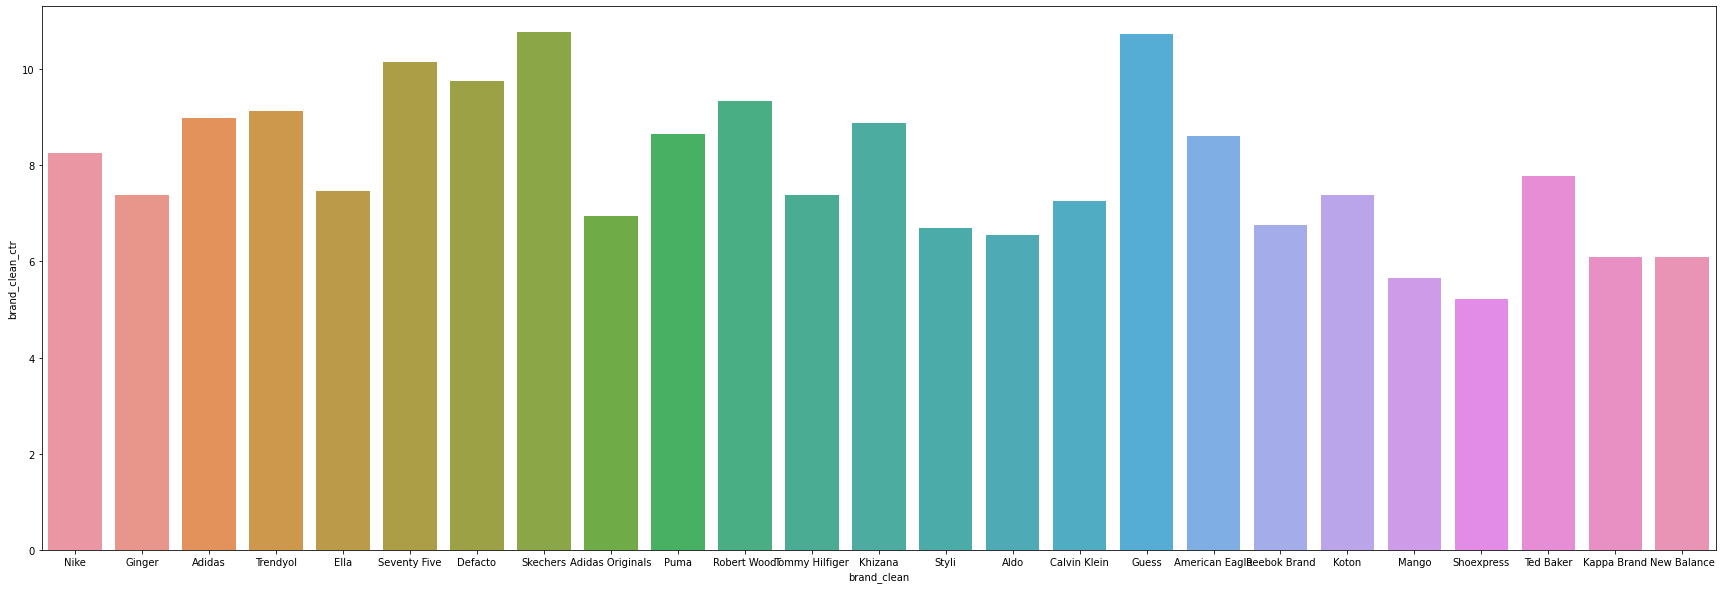

In [33]:
#Top 25 brands ctr distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
sns.barplot(x= temp[:25]['brand_clean'], y = temp[:25]['brand_clean_ctr'])


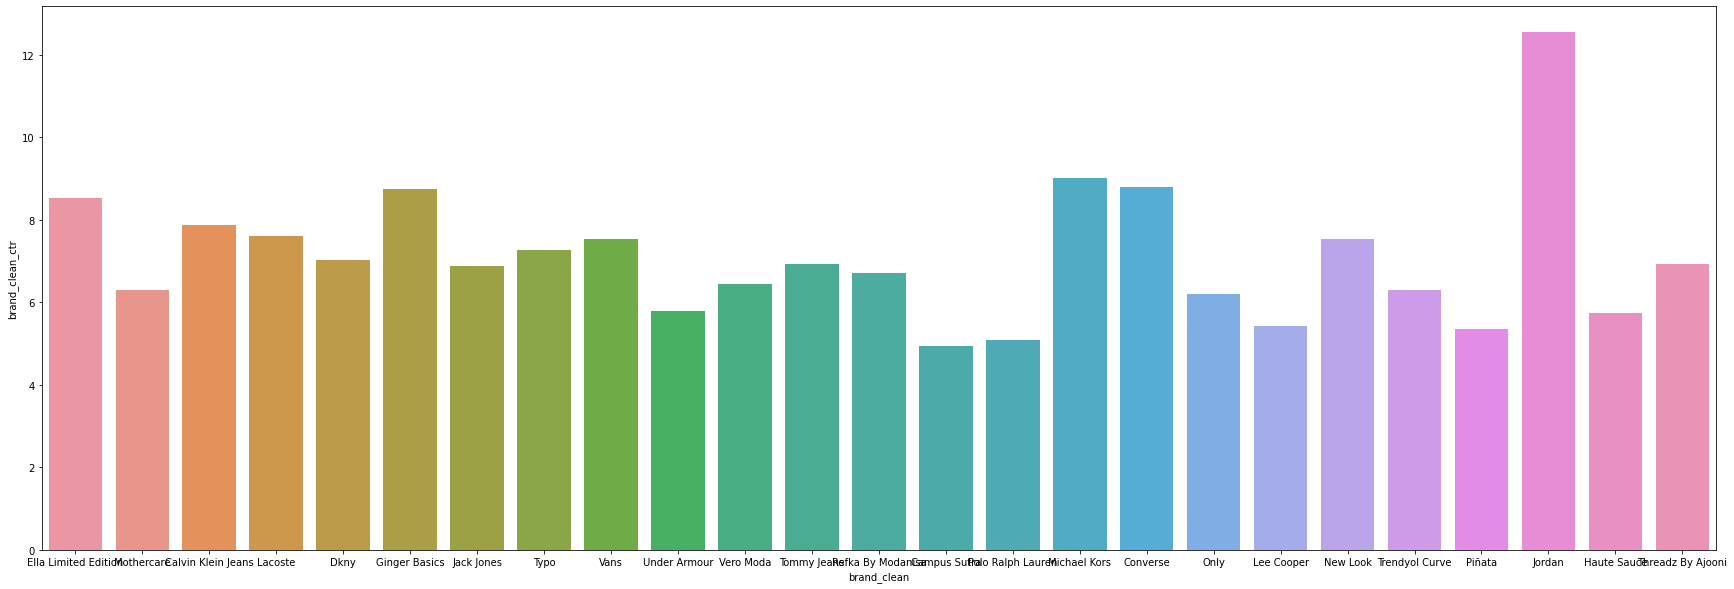

In [34]:
#Next 25 brands ctr distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
sns.barplot(x= temp[25:50]['brand_clean'], y = temp[25:50]['brand_clean_ctr'])

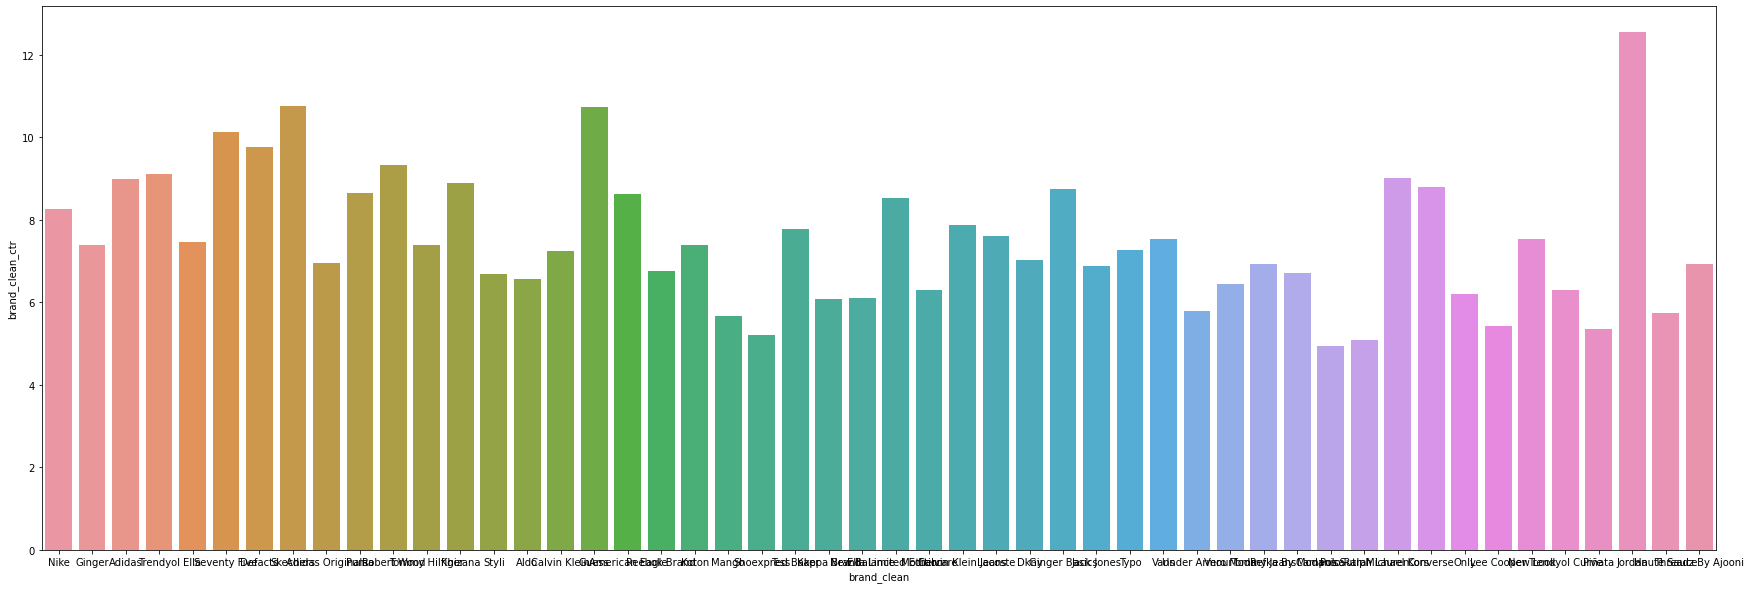

In [35]:
#Overall top 50 ctr distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
sns.barplot(x= temp[:50]['brand_clean'], y = temp[:50]['brand_clean_ctr'])

The median CTR among brands is ~10% and has an IQR range of ~4% (9% to 12%)

Text(0.5, 1.0, 'Brandwise CTR distribution')

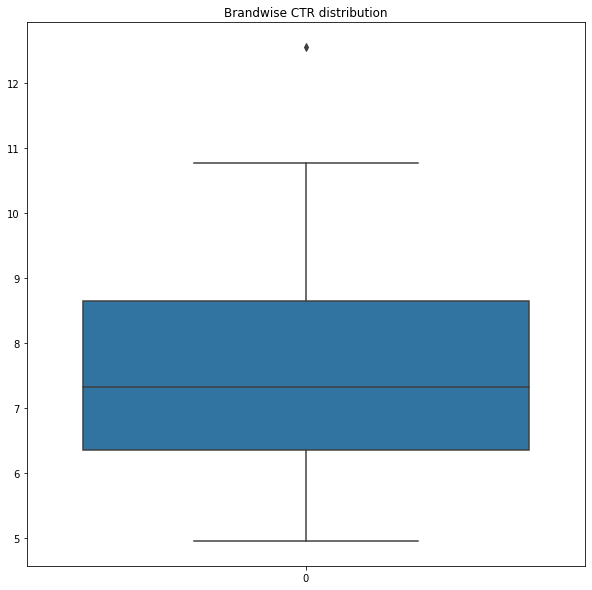

In [36]:
plt.figure(figsize=(10,10))
sns.boxplot( data = temp[:50]['brand_clean_ctr'])
plt.title('Brandwise CTR distribution')

##### Gender wise CTR distribution

In [37]:
temp = df3.groupby(['gender_clean','gender_clean_ctr'],as_index=False)['sku'].count().sort_values('sku',ascending=False).reset_index(drop=True)
temp[:50]

,gender_clean,gender_clean_ctr,sku
0,Female,8.04,24602
1,Male,8.65,14035
2,Unassigned,1.71,1


##### Department wise CTR distribution

In [38]:
temp = df3.groupby(['department','department_ctr'],as_index=False)['sku'].count().sort_values('sku',ascending=False).reset_index(drop=True)
temp[:50]

,department,department_ctr,sku
0,clothing,8.05,18347
1,shoes,8.75,10351
2,accessories,7.37,5470
3,bags,8.53,3773
4,beauty,7.44,697


##### Relationship between time since launch, CTR and Discount

Text(0.5, 1.0, 'discount percentage')

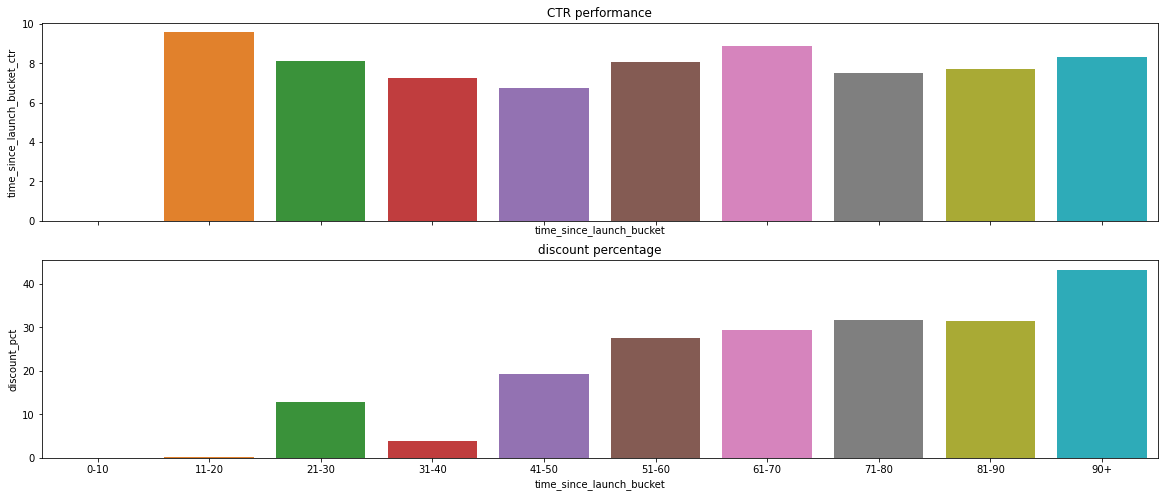

In [39]:
#CTR peaks between 21-30 days and then again from 51-70 days
fig,axes = plt.subplots(2, sharex=True,figsize=(20,8))
temp = df3.groupby(['time_since_launch_bucket','time_since_launch_bucket_ctr'],as_index=False)['sku'].count().sort_values('sku',ascending=False).reset_index(drop=True)
temp.sort_values('time_since_launch_bucket',ascending=True,inplace=True)
temp2 = df3.groupby('time_since_launch_bucket',as_index=False)['discount_pct'].mean()
temp2.sort_values('time_since_launch_bucket',ascending=True,inplace=True)

sns.barplot(ax=axes[0],x= temp['time_since_launch_bucket'],y=temp['time_since_launch_bucket_ctr'])
axes[0].set_title('CTR performance')
sns.barplot(ax=axes[1],x= temp2['time_since_launch_bucket'],y=temp2['discount_pct'])
axes[1].set_title('discount percentage')


Text(0.5, 1.0, 'discount percentage')

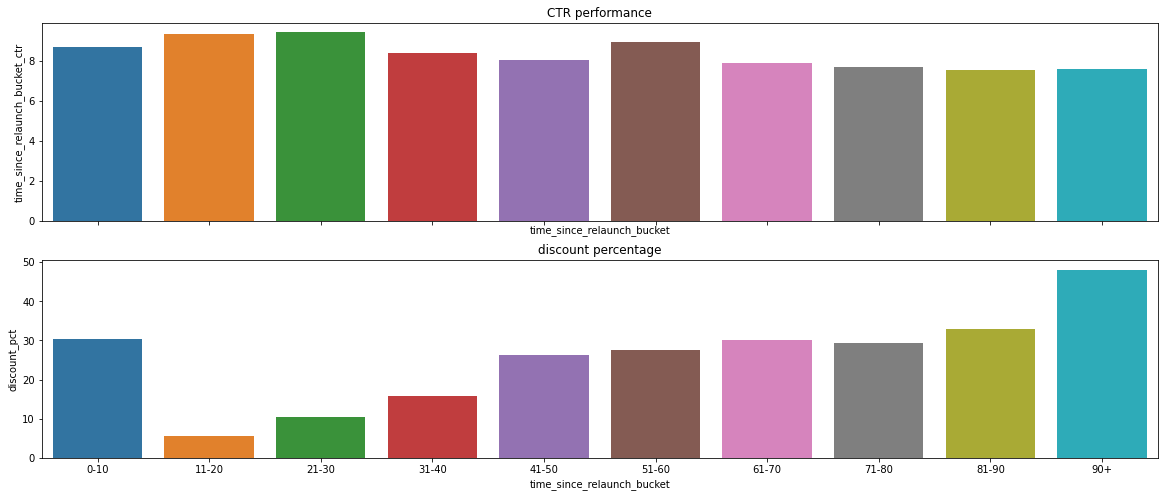

In [40]:
#CTR peaks between 21-30 days and then again from 51-70 days
fig,axes = plt.subplots(2, sharex=True,figsize=(20,8))
temp = df3.groupby(['time_since_relaunch_bucket','time_since_relaunch_bucket_ctr'],as_index=False)['sku'].count().sort_values('sku',ascending=False).reset_index(drop=True)
temp.sort_values('time_since_relaunch_bucket',ascending=True,inplace=True)
temp2 = df3.groupby('time_since_relaunch_bucket',as_index=False)['discount_pct'].mean()
temp2.sort_values('time_since_relaunch_bucket',ascending=True,inplace=True)

sns.barplot(ax=axes[0],x= temp['time_since_relaunch_bucket'],y=temp['time_since_relaunch_bucket_ctr'])
axes[0].set_title('CTR performance')
sns.barplot(ax=axes[1],x= temp2['time_since_relaunch_bucket'],y=temp2['discount_pct'])
axes[1].set_title('discount percentage')

##### Price and CTR relationship

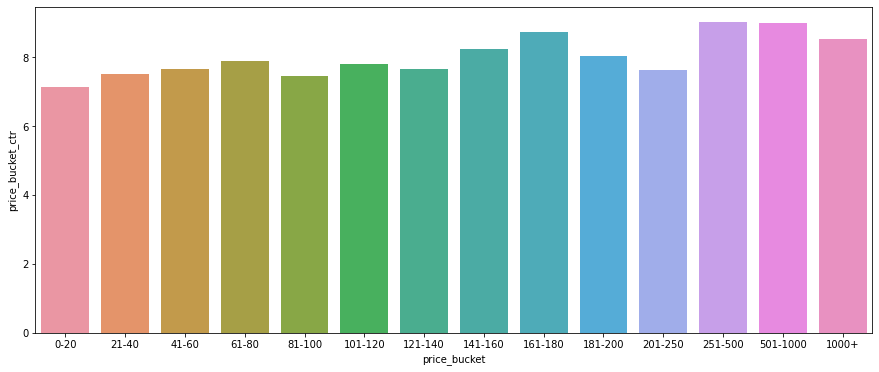

In [41]:
plt.figure(figsize=(15,6))
temp = df3.groupby(['price_bucket','price_bucket_ctr'],as_index=False)['sku'].count()
temp.sort_values('price_bucket',ascending=True,inplace=True)
temp
temp = temp.iloc[[0,8,10,12,13,2,3,4,5,6,7,9,11,1],:]
sns.barplot(x=temp['price_bucket'],y=temp['price_bucket_ctr'] )

In [42]:
# df3.to_pickle('drive/MyDrive/Training Data/final_trainig_data.pkl')
# df3 = pd.read_pickle('drive/MyDrive/Training Data/final_trainig_data.pkl')

#### Creating second training fold to be appended to the first fold

In [43]:
client = bigquery.Client()
df_query1_fold2 = query1_fold2.result().to_dataframe()
print("Shape of the data  for train query 1: ",df_query1_fold2.shape )
df_query2_fold2 = query2_fold2.result().to_dataframe()
print("Shape of the data  for train query 2: ",df_query2_fold2.shape )
df_query3_fold2 = query3_fold2.result().to_dataframe()
print("Shape of the data  for train query 3: ",df_query3_fold2.shape )

df_query1_fold2.to_pickle('drive/MyDrive/Training Data/df_query1_fold2_run2.pkl')
df_query2_fold2.to_pickle('drive/MyDrive/Training Data/df_query2_fold2_run2.pkl')
df_query3_fold2.to_pickle('drive/MyDrive/Training Data/df_query3_fold2_run2.pkl')

temp_skus = df_query1_fold2.groupby('sku',as_index=False)['total_clicks','total_impressions'].sum().sort_values('total_clicks',ascending=False).reset_index(drop=True)
temp_skus['cumsum'] = temp_skus['total_clicks'].cumsum()
temp_skus['contribution'] = temp_skus['cumsum']/temp_skus['cumsum'].max()
skus_to_consider = temp_skus[temp_skus['contribution']<0.9]['sku'].unique()

temp_query_doc = df_query1_fold2.groupby(['sku'],as_index=False)['total_clicks','total_impressions'].sum().sort_values('total_clicks',ascending=False).reset_index(drop=True)
temp_query_doc =  temp_query_doc[(temp_query_doc['sku'].isin(skus_to_consider))]
temp_query_doc = temp_query_doc[temp_query_doc['total_clicks']<temp_query_doc['total_impressions']].reset_index(drop=True)

final_query_doc_trainig_fold2 = temp_query_doc[temp_query_doc['total_impressions']>30][['sku']].drop_duplicates()

#initial filtering of the data
df1_fold2 = df_query1_fold2.merge(final_query_doc_trainig_fold2,on=['sku'])
print("df1_fold2.shape: ",df1_fold2.shape)

df1_agg_fold2 = df1_fold2.groupby(['sku'],as_index=False)['total_impressions','total_clicks'].sum()
df1_agg_fold2['ctr'] = (df1_agg_fold2['total_clicks']/df1_agg_fold2['total_impressions'])
df1_agg_fold2['relevance'] = np.ceil(25 * (df1_agg_fold2['ctr']/df1_agg_fold2['ctr'].max()))

df1_agg_fold2['relevance'] = np.where(df1_agg_fold2['relevance'] >= 15,15,df1_agg_fold2['relevance'])

df_feature_fold2 = import_and_clean_feature_set(df_query2_fold2)
print("df_feature_fold2.shape :",df_feature_fold2.shape)

df2_agg_fold2 = df1_agg_fold2.merge(df_feature_fold2,left_on=['sku'],right_on='sku_config',how = 'left')

df3_fold2 = historical_performance_features(df_query3_fold2, df2_agg_fold2)
df3_fold2.shape


Shape of the data  for train query 1:  (7908028, 5)
Shape of the data  for train query 2:  (1570177, 31)
Shape of the data  for train query 3:  (8338193, 5)
df1_fold2.shape:  (3398590, 5)
df_feature_fold2.shape : (1570177, 32)


(40743, 244)

In [44]:
df3.shape

(38638, 244)

Appending Fold1 (Week-2) and Fold2 (Week-1) training data

In [45]:
df3_final = pd.concat([df3,df3_fold2],axis=0)
df3_final.reset_index(drop=True,inplace=True)
df3_final.shape

(79381, 244)

In [46]:
df3_final['relevance'].value_counts().sort_index()

1.0     11332
2.0     30557
3.0     19120
4.0      9140
5.0      4411
6.0      2196
7.0      1066
8.0       615
9.0       333
10.0      211
11.0      141
12.0       94
13.0       67
14.0       25
15.0       73
Name: relevance, dtype: int64

#### Sample training data

In [47]:
pd.set_option('display.max_columns',None)
df3_final[X+y].head()

,time_since_launch,time_since_relaunch,current_price,discount_pct,availability_dxb_pct,relaunch_flag,brand_clean_ctr,department_ctr,category_clean_ctr,subcategory_clean_ctr,gender_clean_ctr,color_ctr,occasion_ctr,inventory_group_clean_ctr,basic_type_ctr,specialist_ctr,merch_team_clean_ctr,time_since_launch_bucket_ctr,time_since_relaunch_bucket_ctr,discount_bucket_ctr,price_bucket_ctr,brand_clean-department_ctr,brand_clean-category_clean_ctr,brand_clean-subcategory_clean_ctr,brand_clean-gender_clean_ctr,brand_clean-color_ctr,brand_clean-occasion_ctr,brand_clean-inventory_group_clean_ctr,brand_clean-basic_type_ctr,brand_clean-specialist_ctr,brand_clean-merch_team_clean_ctr,brand_clean-time_since_launch_bucket_ctr,brand_clean-time_since_relaunch_bucket_ctr,brand_clean-discount_bucket_ctr,brand_clean-price_bucket_ctr,department-category_clean_ctr,department-subcategory_clean_ctr,department-gender_clean_ctr,department-color_ctr,department-occasion_ctr,department-inventory_group_clean_ctr,department-basic_type_ctr,department-specialist_ctr,department-merch_team_clean_ctr,department-time_since_launch_bucket_ctr,department-time_since_relaunch_bucket_ctr,department-discount_bucket_ctr,department-price_bucket_ctr,category_clean-subcategory_clean_ctr,category_clean-gender_clean_ctr,category_clean-color_ctr,category_clean-occasion_ctr,category_clean-inventory_group_clean_ctr,category_clean-basic_type_ctr,category_clean-specialist_ctr,category_clean-merch_team_clean_ctr,category_clean-time_since_launch_bucket_ctr,category_clean-time_since_relaunch_bucket_ctr,category_clean-discount_bucket_ctr,category_clean-price_bucket_ctr,subcategory_clean-gender_clean_ctr,subcategory_clean-color_ctr,subcategory_clean-occasion_ctr,subcategory_clean-inventory_group_clean_ctr,subcategory_clean-basic_type_ctr,subcategory_clean-specialist_ctr,subcategory_clean-merch_team_clean_ctr,subcategory_clean-time_since_launch_bucket_ctr,subcategory_clean-time_since_relaunch_bucket_ctr,subcategory_clean-discount_bucket_ctr,subcategory_clean-price_bucket_ctr,gender_clean-color_ctr,gender_clean-occasion_ctr,gender_clean-inventory_group_clean_ctr,gender_clean-basic_type_ctr,gender_clean-specialist_ctr,gender_clean-merch_team_clean_ctr,gender_clean-time_since_launch_bucket_ctr,gender_clean-time_since_relaunch_bucket_ctr,gender_clean-discount_bucket_ctr,gender_clean-price_bucket_ctr,color-occasion_ctr,color-inventory_group_clean_ctr,color-basic_type_ctr,color-specialist_ctr,color-merch_team_clean_ctr,color-time_since_launch_bucket_ctr,color-time_since_relaunch_bucket_ctr,color-discount_bucket_ctr,color-price_bucket_ctr,occasion-inventory_group_clean_ctr,occasion-basic_type_ctr,occasion-specialist_ctr,occasion-merch_team_clean_ctr,occasion-time_since_launch_bucket_ctr,occasion-time_since_relaunch_bucket_ctr,occasion-discount_bucket_ctr,occasion-price_bucket_ctr,inventory_group_clean-basic_type_ctr,inventory_group_clean-specialist_ctr,inventory_group_clean-merch_team_clean_ctr,inventory_group_clean-time_since_launch_bucket_ctr,inventory_group_clean-time_since_relaunch_bucket_ctr,inventory_group_clean-discount_bucket_ctr,inventory_group_clean-price_bucket_ctr,basic_type-specialist_ctr,basic_type-merch_team_clean_ctr,basic_type-time_since_launch_bucket_ctr,basic_type-time_since_relaunch_bucket_ctr,basic_type-discount_bucket_ctr,basic_type-price_bucket_ctr,specialist-merch_team_clean_ctr,specialist-time_since_launch_bucket_ctr,specialist-time_since_relaunch_bucket_ctr,specialist-discount_bucket_ctr,specialist-price_bucket_ctr,merch_team_clean-time_since_launch_bucket_ctr,merch_team_clean-time_since_relaunch_bucket_ctr,merch_team_clean-discount_bucket_ctr,merch_team_clean-price_bucket_ctr,time_since_launch_bucket-time_since_relaunch_bucket_ctr,time_since_launch_bucket-discount_bucket_ctr,time_since_launch_bucket-price_bucket_ctr,time_since_relaunch_bucket-discount_bucket_ctr,time_since_relaunch_bucket-price_bucket_ctr,discount_bucket-price_bucket_ctr,gender_clean-brand_clean-depa

#### **Training**

Hyperparameter tuning and selecting best performing model based on root mean squared error

All In Model

In [48]:
from sklearn.model_selection import train_test_split
training_data = df3_final[X+y]
  

from sklearn.model_selection import cross_val_score, KFold
xtrain, xtest, ytrain, ytest=train_test_split(training_data[X], training_data[y], test_size=0.15)
ytrain['relevance'] = ytrain['relevance'].astype(int)
ytest['relevance'] = ytest['relevance'].astype(int)

#Hyperparameter grid
params = {
    'n_estimators':[100,110,150],

    #Minimum sum of instance weight needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. The larger min_child_weight is, the more conservative the algorithm will be.
    'min_child_weight':[4,5],

    # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be 
    'gamma':[0.5,0.6], 

    #Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. 
    'subsample':[0.5,0.6],

     #the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    'colsample_bytree':[0.6], 

    #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value
    'max_depth': [3,4,6],
    
    'eval_metric': ['rmse'],

    #Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
    'eta': [0.05,0.1,0.5],
}

xgbr = xgb.XGBRegressor(booster='gbtree',
objective='reg:squarederror',
random_state=42, 
learning_rate=0.1,
colsample_bytree=0.9, 
eta=0.1, 
max_depth=4, 
n_estimators=150, 
subsample=0.75)
# run randomized search
# n_iter_search = 25
# random_search = RandomizedSearchCV(xgbr, param_distributions=params,
#                                    n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

# start = time.time()
# random_search.fit(xtrain, ytrain)

# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))

#random_search.best_estimator_
#best_model = random_search.best_estimator_

Fit the model

In [49]:
xgbr.fit(xtrain, ytrain)

XGBRegressor(colsample_bytree=0.9, eta=0.1, max_depth=4, n_estimators=150,
             objective='reg:squarederror', random_state=42, subsample=0.75)

In [50]:
pickle.dump(xgbr, open('drive/MyDrive/Training Data/xgbr_run2_all_in.pkl', 'wb'))

#### Training Error

In [51]:
def train_error_estimation(model,xtrain,ytrain,ndcg_k=25):
    prediction = model.predict(xtrain)
    train_data = xtrain.merge(df3_final[['sku','brand_clean','department', 'category_clean',
                                  'subcategory_clean', 'gender_clean','total_impressions', 'total_clicks', 'ctr']],left_index=True, right_index=True,how='left')

    train_data = train_data.merge(ytrain,left_index=True, right_index=True,how='left')

    train_data = pd.concat([train_data.reset_index(drop=True),pd.Series(prediction)],axis=1)
    train_data.rename(columns={ train_data.columns[len(train_data.columns)-1]: "Prediction_val" }, inplace = True)
    top_25_gdc = train_data.groupby(['gender_clean','department','category_clean'],as_index=False).agg({'brand_clean':'count','total_clicks':'sum'}).sort_values('brand_clean',ascending=False)[:25]
    top_25_gdc.reset_index(drop=True,inplace=True)
    top_25_gdc['ndcg'] = 0
    top_25_gdc.rename({'brand_clean':'total_skus','total_clicks':'total_clicks_combination'},axis=1,inplace=True)

    for index, row in top_25_gdc.iterrows():
      true_relevance = np.asarray([train_data[(train_data['gender_clean']==row['gender_clean']) & (train_data['department']==row['department']) & (train_data['category_clean']==row['category_clean'])]['relevance']])
      predicted_relevance = np.asarray([train_data[(train_data['gender_clean']==row['gender_clean']) & (train_data['department']==row['department']) & (train_data['category_clean']==row['category_clean'])]['Prediction_val']])
      top_25_gdc.loc[index,'ndcg'] = np.round(ndcg_score(true_relevance, predicted_relevance,k=ndcg_k),2)
    
    weighted_ndcg=(top_25_gdc['total_skus'] * top_25_gdc['ndcg']).values.sum()/top_25_gdc['total_skus'].sum() 
    #print('Weighted Average NDCG for top 25 categories: ',str(weighted_ndcg))
    return top_25_gdc,weighted_ndcg,train_data
top_25_gdc ,weighted_ndcg,train_data =  train_error_estimation(xgbr,xtrain,ytrain)
print(weighted_ndcg)
top_25_gdc

0.7834969367071309


,gender_clean,department,category_clean,total_skus,total_clicks_combination,ndcg
0,Female,clothing,Dresses,4790,364413,0.79
1,Female,bags,Handbags,3724,310511,0.77
2,Male,shoes,Sneakers,3111,154744,0.81
3,Male,shoes,Sports Shoes,2721,198815,0.83
4,Female,clothing,Arabian Clothing,2416,125580,0.76
5,Female,shoes,Sneakers,2367,119622,0.77
6,Female,shoes,Sports Shoes,1899,128008,0.91
7,Male,clothing,T-Shirts & Vests,1875,43963,0.78
8,Female,clothing,Hoodies & Sweatshirts,1652,89868,0.73
9,Male,clothing,Hoodies & Sweatshirts,1603,67991,0.86


#### Model evaluation using validation data (25% held back during train-test split)

In [52]:
def validation_error_estimation(model,xtest,ytest,ndcg_k=25):    
    prediction = model.predict(xtest)
    test_data = xtest.merge(df3_final[['sku','brand_clean','department', 'category_clean',
                                  'subcategory_clean', 'gender_clean','total_impressions', 'total_clicks', 'ctr']],left_index=True, right_index=True,how='left')

    test_data = test_data.merge(ytest,left_index=True, right_index=True,how='left')

    test_data = pd.concat([test_data.reset_index(drop=True),pd.Series(prediction)],axis=1)
    test_data.rename(columns={ test_data.columns[len(test_data.columns)-1]: "Prediction_val" }, inplace = True)
    top_25_gdc = test_data.groupby(['gender_clean','department','category_clean'],as_index=False).agg({'brand_clean':'count','total_clicks':'sum'}).sort_values('brand_clean',ascending=False)[:25]
    top_25_gdc.reset_index(drop=True,inplace=True)
    top_25_gdc['ndcg'] = 0
    top_25_gdc.rename({'brand_clean':'total_skus','total_clicks':'total_clicks_combination'},axis=1,inplace=True)

    for index, row in top_25_gdc.iterrows():
      true_relevance = np.asarray([test_data[(test_data['gender_clean']==row['gender_clean']) & (test_data['department']==row['department']) & (test_data['category_clean']==row['category_clean'])]['relevance']])
      predicted_relevance = np.asarray([test_data[(test_data['gender_clean']==row['gender_clean']) & (test_data['department']==row['department']) & (test_data['category_clean']==row['category_clean'])]['Prediction_val']])
      top_25_gdc.loc[index,'ndcg'] = np.round(ndcg_score(true_relevance, predicted_relevance,k=ndcg_k),2)
    weighted_ndcg=(top_25_gdc['total_skus'] * top_25_gdc['ndcg']).values.sum()/top_25_gdc['total_skus'].sum() 
    #print('Weighted Average NDCG for top 25 categories: ',str(weighted_ndcg))
    return top_25_gdc,weighted_ndcg,test_data
top_25_gdc ,weighted_ndcg,test_data =  validation_error_estimation(xgbr,xtest,ytest)
print(weighted_ndcg)
top_25_gdc


0.7423419930205506


,gender_clean,department,category_clean,total_skus,total_clicks_combination,ndcg
0,Female,clothing,Dresses,834,36926,0.68
1,Female,bags,Handbags,679,40134,0.68
2,Male,shoes,Sneakers,570,21676,0.77
3,Male,shoes,Sports Shoes,490,36028,0.78
4,Female,clothing,Arabian Clothing,454,27953,0.69
5,Female,shoes,Sneakers,412,19521,0.72
6,Female,shoes,Sports Shoes,323,26245,0.84
7,Male,clothing,T-Shirts & Vests,308,6708,0.65
8,Male,clothing,Hoodies & Sweatshirts,297,12006,0.81
9,Female,clothing,Jackets & Coats,274,9445,0.67


#### Gini based feature Importance

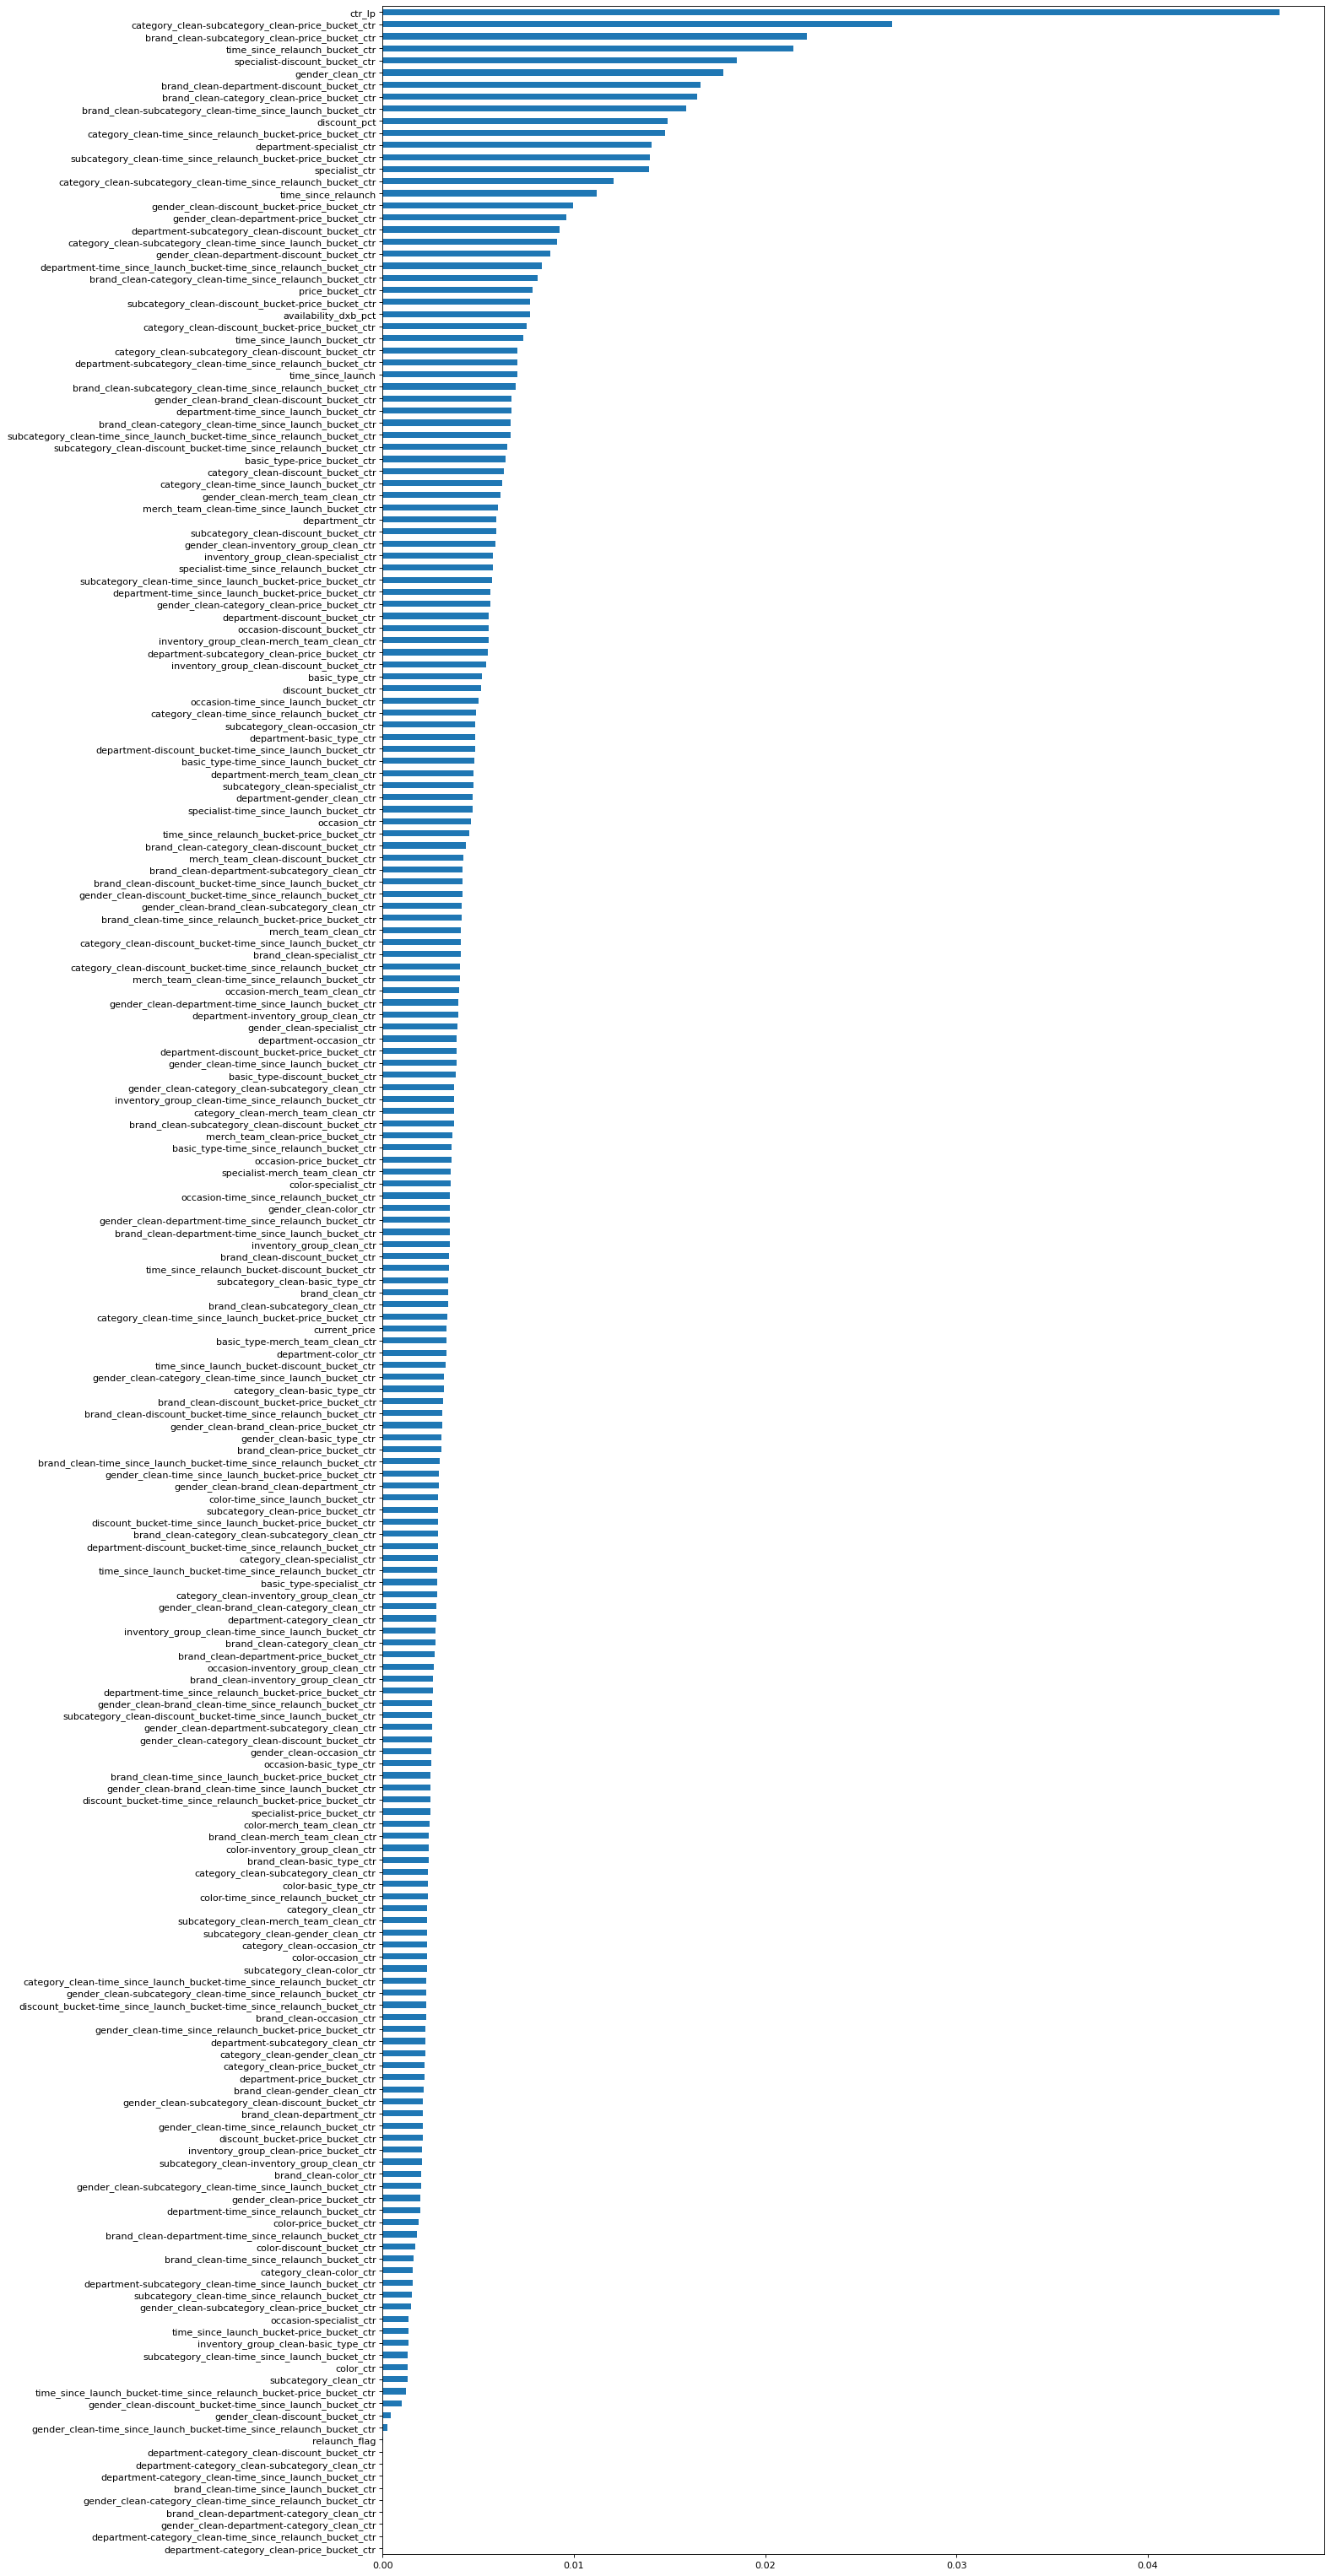

In [53]:
f = X.copy()
feature_names= f

importances = xgbr.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

from matplotlib.pyplot import figure

figure(figsize=(18, 50), dpi=80)
forest_importances.sort_values(ascending=True).plot(kind='barh')

#### SHAP based feature importance

In this chart, the x-axis stands for SHAP value, and the y-axis has all the features. Each point on the chart is one SHAP value for a prediction and feature. Red color means higher value of a feature. Blue means lower value of a feature. We can get the general sense of features’ directionality impact based on the distribution of the red and blue dots.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.7 MB/s 


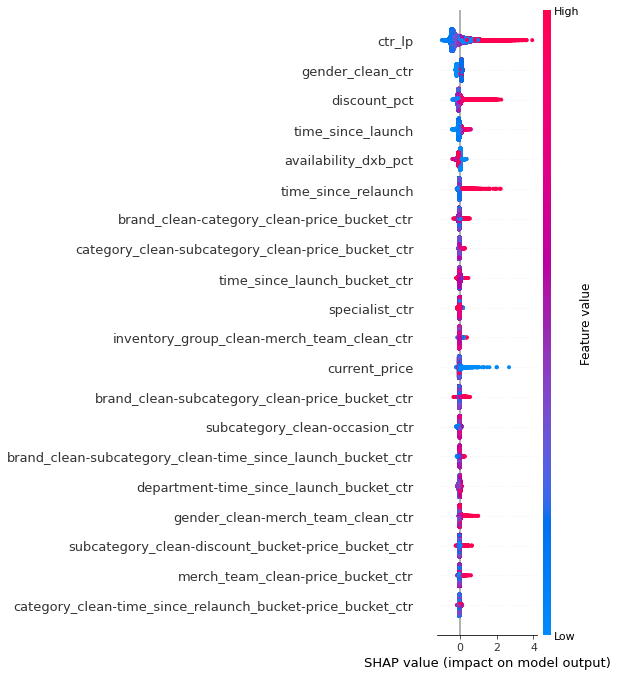

In [54]:
! pip install shap
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgbr)
shap_values = explainer.shap_values(df3_final[feature_names])
shap.summary_plot(shap_values, features=df3_final[feature_names], feature_names=feature_names)

In [55]:
rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
210,ctr_lp,0.362328
10,gender_clean_ctr,0.100868
3,discount_pct,0.084755
0,time_since_launch,0.070598
4,availability_dxb_pct,0.053636
...,...,...
176,department-category_clean-discount_bucket_ctr,0.000000
175,department-category_clean-subcategory_clean_ctr,0.000000
154,brand_clean-department-category_clean_ctr,0.000000
142,gender_clean-category_clean-time_since_relaunc...,0.000000


#### Checking the model performance under different 'N' top SHAP features

In [56]:
from sklearn.metrics import mean_squared_error
topN = [2,5,10,15,20,25,30,35,40,45,50,55,60,70,80,90,100,120,140,160,180,200,220,240]
train_ndcg = []
test_ndcg = []
train_rmse=[]
test_rmse=[]
for n in topN:
  print(n)
  y1=['relevance']
  X1 = list(shap_importance[:n]['col_name'])
  training_data = df3_final[X1+y1]
  xtrain, xtest, ytrain, ytest=train_test_split(training_data[X1], training_data[y1], test_size=0.25)
  ytrain['relevance'] = ytrain['relevance'].astype(int)
  ytest['relevance'] = ytest['relevance'].astype(int)
  xgbr = xgb.XGBRegressor(booster='gbtree',
  objective='reg:squarederror',
  random_state=42, 
  learning_rate=0.1,
  colsample_bytree=0.9, 
  eta=0.1, 
  max_depth=4, 
  n_estimators=150, 
  subsample=0.75)
  xgbr.fit(xtrain, ytrain)
  pred = xgbr.predict(xtrain)
  train_rmse.append(mean_squared_error(ytrain,pred))
  pred = xgbr.predict(xtest)
  test_rmse.append(mean_squared_error(ytest,pred))
  top_25_gdc_train ,weighted_ndcg_train,train_data =  train_error_estimation(xgbr,xtrain,ytrain)
  top_25_gdc_test ,weighted_ndcg_test, test_data =  validation_error_estimation(xgbr,xtest,ytest)
  train_ndcg.append(weighted_ndcg_train)
  test_ndcg.append(weighted_ndcg_test)

2
5
10
15
20
25
30
35
40
45
50
55
60
70
80
90
100
120
140
160
180
200
220
240


The Top 50 features can gives best accuracy with highest validation accuracy. 

Also, The gap between training eror and validation error is not big @ top 50

Beyond that adding more features does not add any addition value to the overall performance of the model

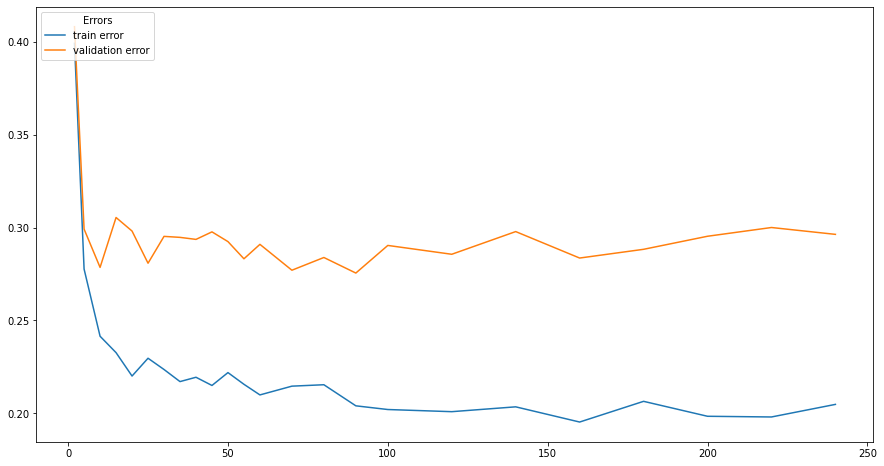

In [57]:
fig, ax = plt.subplots(figsize=(15,8))

train_ndcg2 = [1-i for i in train_ndcg]
test_ndcg2 = [1-i for i in test_ndcg]

ax = sns.lineplot(x=topN,y=train_ndcg2)

ax1 = sns.lineplot(x=topN,y=test_ndcg2)

plt.legend(title='Errors', loc='upper left', labels=['train error', 'validation error'])

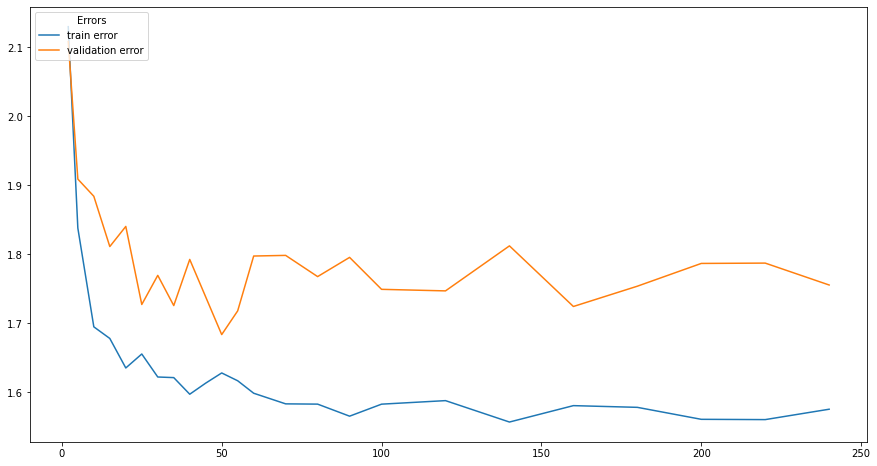

In [58]:
fig, ax = plt.subplots(figsize=(15,8))

ax = sns.lineplot(x=topN,y=train_rmse)

ax1 = sns.lineplot(x=topN,y=test_rmse)

plt.legend(title='Errors', loc='upper left', labels=['train error', 'validation error'])

Model using top 45 features

In [59]:
y1=['relevance']
X1 = list(shap_importance[:45]['col_name'])
training_data = df3_final[X1+y1]
xtrain, xtest, ytrain, ytest=train_test_split(training_data[X1], training_data[y1], test_size=0.25)
ytrain['relevance'] = ytrain['relevance'].astype(int)
ytest['relevance'] = ytest['relevance'].astype(int)
xgbr = xgb.XGBRegressor(booster='gbtree',
objective='reg:squarederror',
random_state=42, 
learning_rate=0.05,
colsample_bytree=0.75, 
eta=0.05, 
max_depth=5, 
n_estimators=500, 
subsample=0.75)

xgbr.fit(xtrain,ytrain)

top_25_gdc_train ,weighted_ndcg_train, train_data_op =  train_error_estimation(xgbr,xtrain,ytrain)
top_25_gdc_test ,weighted_ndcg_test,test_data_op =  validation_error_estimation(xgbr,xtest,ytest)


In [79]:
pickle.dump(xgbr, open('drive/MyDrive/Training Data/xgbr_run2_4_1.pkl', 'wb'))

Validation NDCG

In [60]:
print(weighted_ndcg_test)
top_25_gdc_test

0.7315873628920129


,gender_clean,department,category_clean,total_skus,total_clicks_combination,ndcg
0,Female,clothing,Dresses,1414,84151,0.76
1,Female,bags,Handbags,1144,87167,0.74
2,Male,shoes,Sneakers,905,40698,0.72
3,Male,shoes,Sports Shoes,784,57129,0.72
4,Female,clothing,Arabian Clothing,727,38358,0.63
5,Female,shoes,Sneakers,726,24897,0.65
6,Female,shoes,Sports Shoes,540,30798,0.87
7,Male,clothing,T-Shirts & Vests,521,10735,0.73
8,Male,clothing,Hoodies & Sweatshirts,505,15851,0.73
9,Female,clothing,Jackets & Coats,480,19218,0.66


#### Hyper parameter tuning

In [61]:
# y1=['relevance']
# X1 = list(shap_importance[:45]['col_name'])
# training_data = df3_final[X1+y1]
# xtrain, xtest, ytrain, ytest=train_test_split(training_data[X1], training_data[y1], test_size=0.25)
# ytrain['relevance'] = ytrain['relevance'].astype(int)
# ytest['relevance'] = ytest['relevance'].astype(int)

# #Hyperparameter grid
# params = {
#     'n_estimators':[100,200,500,1000],

#     #Minimum sum of instance weight needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. The larger min_child_weight is, the more conservative the algorithm will be.
#     'min_child_weight':[4,6],

#     # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be 
#     'gamma':[0.5,0.8], 

#     #Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. 
#     'subsample':[0.5,0.8],

#      #the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
#     'colsample_bytree':[0.5,0.8], 

#     #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value
#     'max_depth': [3,5],
    
#     'eval_metric': ['rmse'],

#     #Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
#     'eta': [0.05,0.1,0.5],
# }

# xgbr_rs = xgb.XGBRegressor()

# #run randomized search
# n_iter_search = 25
# random_search = RandomizedSearchCV(xgbr_rs, param_distributions=params,
#                                    n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

# start = time.time()
# random_search.fit(xtrain, ytrain)

# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))

# random_search.best_estimator_
# best_model = random_search.best_estimator_

In [62]:
# pickle.dump(best_model, open('drive/MyDrive/Training Data/best_model_run2.pkl', 'wb'))

In [63]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
import numpy as np

project = 'namshi-datahut' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

job_query = client.query(

'''


select sku_config,bidc,coalesce(round(safe_divide(sum(ttl_clicks_AE),sum(ttl_impressions_AE))*100,2),0) as ctr
from `namshi-datagrill.sabio_gold.daily_product_summary` 
where date_key > current_date()-30 
group by 1,2
order by 3 desc

'''
)

df_skus_details = job_query.result().to_dataframe()
df_skus_details = df_skus_details.dropna()
df_skus_details['reverse_bidc'] = df_skus_details['bidc'].apply(lambda x: x[::-1])
df_skus_details['url_part1'] = df_skus_details['reverse_bidc'].apply(lambda x: x[:2])
df_skus_details['url_part2'] = df_skus_details['reverse_bidc'].apply(lambda x: x[2:])
df_skus_details['url'] = "https://pa.namshicdn.com/product/" + df_skus_details['url_part1'] +"/"+df_skus_details['url_part2'][2:]+"/1-zoom-desktop.webp"
df_skus_details

,sku_config,bidc,ctr,reverse_bidc,url_part1,url_part2,url
0,12232SHHCRYP,W863151A,100.0,A151368W,A1,51368W,NaN
1,19872ACJKPVP,W1232104A,100.0,A4012321W,A4,012321W,NaN
2,18840ATYEJTP,W1004486A,100.0,A6844001W,A6,844001W,https://pa.namshicdn.com/product/A6/844001W/1-...
3,18832ATHJERP,W1264634A,100.0,A4364621W,A4,364621W,https://pa.namshicdn.com/product/A4/364621W/1-...
4,24424ATKQRYP,W1113338A,100.0,A8333111W,A8,333111W,https://pa.namshicdn.com/product/A8/333111W/1-...
...,...,...,...,...,...,...,...
1580531,32136ATOCAAP,MP515730001221,0.0,122100037515PM,12,2100037515PM,https://pa.namshicdn.com/product/12/2100037515...
1580532,30936SHNXXEP,W1604684A,0.0,A4864061W,A4,864061W,https://pa.namshicdn.com/product/A4/864061W/1-...
1580533,11096ACCWGLP,W411100A,0.0,A001114W,A0,01114W,https://pa.namshicdn.com/product/A0/01114W/1-z...
1580534,42160ATMGVFP,W1537832A,0.0,A2387351W,A2,387351W,https://pa.namshicdn.com/product/A2/387351W/1-...


Output snapshot Validation

In [64]:
#test for male shoes sneakers
temp = test_data_op[(test_data_op['gender_clean']=='Male') & (test_data_op['department']=='shoes') & (test_data_op['category_clean']=='Sneakers')].sort_values('Prediction_val',ascending=False)
# temp = temp[temp['relevance'] <= 8]
# temp['relevance_rank'] = temp['relevance'].rank(ascending=False,method='first')
# temp['predicted_rank'] = temp['Prediction_val'].rank(ascending=False,method='first')
temp = temp.merge(df_skus_details[['sku_config','url']],left_on='sku',right_on='sku_config')
#'<img src="'+ path + '" style=max-height:124px;max-width:200px;"/>'

import pandas as pd
from IPython.display import Image, HTML

def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:200px;max-width:200px;height:auto;width:auto;"/>'

HTML(temp[:25].to_html(escape=False ,formatters=dict(url=path_to_image_html)))


,ctr_lp,gender_clean_ctr,discount_pct,time_since_launch,availability_dxb_pct,time_since_relaunch,brand_clean-category_clean-price_bucket_ctr,category_clean-subcategory_clean-price_bucket_ctr,time_since_launch_bucket_ctr,specialist_ctr,inventory_group_clean-merch_team_clean_ctr,current_price,brand_clean-subcategory_clean-price_bucket_ctr,subcategory_clean-occasion_ctr,brand_clean-subcategory_clean-time_since_launch_bucket_ctr,department-time_since_launch_bucket_ctr,gender_clean-merch_team_clean_ctr,subcategory_clean-discount_bucket-price_bucket_ctr,merch_team_clean-price_bucket_ctr,category_clean-time_since_relaunch_bucket-price_bucket_ctr,subcategory_clean-time_since_relaunch_bucket-price_bucket_ctr,brand_clean-category_clean-time_since_relaunch_bucket_ctr,brand_clean-department-discount_bucket_ctr,department-merch_team_clean_ctr,department_ctr,brand_clean_ctr,merch_team_clean-time_since_relaunch_bucket_ctr,category_clean-specialist_ctr,department-specialist_ctr,basic_type_ctr,brand_clean-category_clean-discount_bucket_ctr,occasion_ctr,department-basic_type_ctr,category_clean-subcategory_clean-time_since_relaunch_bucket_ctr,occasion-merch_team_clean_ctr,inventory_group_clean-specialist_ctr,subcategory_clean-time_since_launch_bucket-time_since_relaunch_bucket_ctr,specialist-discount_bucket_ctr,occasion-discount_bucket_ctr,department-time_since_launch_bucket-price_bucket_ctr,color-basic_type_ctr,subcategory_clean-time_since_launch_bucket-price_bucket_ctr,category_clean-subcategory_clean-time_since_launch_bucket_ctr,gender_clean-category_clean-subcategory_clean_ctr,brand_clean-gender_clean_ctr,sku,brand_clean,department,category_clean,subcategory_clean,gender_clean,total_impressions,total_clicks,ctr,relevance,Prediction_val,sku_config,url
0,0.00,8.65,81.00,490,0.00,483,18.67,14.75,8.35,8.32,9.63,23.000000,18.67,8.26,10.31,9.55,9.62,0.00,7.57,15.54,15.66,10.25,0.00,9.58,8.75,10.14,9.41,8.64,7.73,8.54,0.00,7.96,8.64,8.24,9.81,8.66,8.24,13.22,13.92,6.06,9.48,15.66,9.00,9.00,10.15,11136SHKVGMP,Seventy Five,shoes,Sneakers,Low-Top Sneakers,Male,112,48,0.428571,14,10.104659,11136SHKVGMP,
1,35.51,8.79,61.00,701,8.57,13,29.10,16.77,8.28,8.59,8.77,167.000000,35.48,9.42,11.97,9.77,9.00,35.51,8.82,33.66,35.51,21.80,27.44,9.58,9.04,7.19,12.82,9.16,9.58,8.51,34.30,8.36,8.73,13.89,8.59,8.77,24.99,15.00,12.16,10.06,9.17,17.72,10.64,8.79,8.43,14448SH01QVP,Adidas Originals,shoes,Sneakers,Low - Top,Male,676,200,0.295858,8,8.811199,14448SH01QVP,
2,17.36,8.65,62.00,811,0.00,144,18.67,14.75,8.35,8.32,9.63,38.000000,18.67,8.26,10.31,9.55,9.62,17.48,7.57,15.54,15.66,10.25,14.19,9.58,8.75,10.14,9.41,8.64,7.73,8.54,13.32,7.96,8.64,8.24,9.81,8.66,8.24,6.65,6.41,6.06,9.48,15.66,9.00,9.00,10.15,11136SH43FNP,Seventy Five,shoes,Sneakers,Low-Top Sneakers,Male,100,16,0.16,6,8.679267,11136SH43FNP,
3,0.00,8.79,65.43,417,0.00,340,10.59,8.81,8.28,8.59,8.77,136.285714,0.00,9.07,9.57,9.77,9.00,17.01,8.65,12.28,11.74,9.51,0.00,9.58,9.04,9.87,7.91,9.16,9.58,8.51,0.00,7.74,8.73,7.32,7.74,8.77,7.32,15.00,11.67,11.37,8.79,11.22,8.49,8.97,9.48,49032SHYCOMP,Converse,shoes,Sneakers,Low-Top Sneakers,Male,490,115,0.234694,7,8.429168,49032SHYCOMP,
4,23.47,8.65,64.00,417,0.00,346,19.35,6.94,8.35,8.42,8.62,142.000000,23.47,9.02,8.27,9.55,8.72,11.61,8.81,7.55,8.47,11.63,23.47,9.38,8.75,8.80,7.34,9.09,9.38,8.54,23.47,7.78,8.64,8.24,7.78,8.62,8.24,7.34,7.60,10.70,8.05,8.33,9.00,9.00,8.79,49032SHYCOMP,Converse,shoes,Sneakers,Low-Top Sneakers,Male,604,152,0.251656,9,7.251344,49032SHYCOMP,
5,17.76,8.65,66.00,235,0.00,226,18.67,14.75,8.35,8.32,9.63,40.000000,18.67,8.26,10.31,9.55,9.62,17.48,7.57,15.54,15.66,10.25,14.19,9.58,8.75,10.14,9.41,8.64,7.73,8.54,13.32,7.96,8.64,8.24,9.81,8.66,8.24,6.65,6.41,6.06,9.48,15.66,9.00,9.00,10.15,11136SHXKBEP,Seventy Five,shoes,Sneakers,Low-Top Sneakers,Male,212,76,0.358491,12,8.198681,11136SHXKBEP,
6,7.88,8.79,66.00,235,4.71,219,11.83,11.36,8.28,8.17,9.48,40.000000,11.83,8.78,9.06,9.77,9.42,11.40,6.73,10.73,10.74,7.83,8.81,9.19,9.04,10.18,8.02,9.04,8.0

### ***10.Test Case : Checking accuracy for last 1 week using above model trainied on (current_date-3 to current_date-10)***

##### Test main

In [65]:
temp_skus = df_query1_test.groupby('sku',as_index=False)['total_clicks','total_impressions'].sum().sort_values('total_clicks',ascending=False).reset_index(drop=True)
temp_skus['cumsum'] = temp_skus['total_clicks'].cumsum()
temp_skus['contribution'] = temp_skus['cumsum']/temp_skus['cumsum'].max()
skus_to_consider = temp_skus[temp_skus['contribution']<0.9]['sku'].unique()
temp_skus[temp_skus['contribution']<0.9].sort_values(['contribution'],ascending=False)


,sku,total_clicks,total_impressions,cumsum,contribution
39558,8008SHRCTFP,5,118,1560445,0.899998
39557,27680ATYPGHP,5,212,1560440,0.899995
39556,29928ACSFAUP,5,133,1560435,0.899992
39555,13288ACCLLJP,5,112,1560430,0.899989
39554,50032ATJCMQP,5,56,1560425,0.899986
...,...,...,...,...,...
4,72704SHXCLXP,6688,68507,40593,0.023412
3,40936ATNZFEP,6926,70529,33905,0.019555
2,27680ATKIMMP,6931,59135,26979,0.01556
1,14448ATWGDNP,7309,84548,20048,0.011563


In [66]:
temp_query_doc = df_query1_test.groupby(['sku'],as_index=False)['total_clicks','total_impressions'].sum().sort_values('total_clicks',ascending=False).reset_index(drop=True)
temp_query_doc =  temp_query_doc[(temp_query_doc['sku'].isin(skus_to_consider))]
temp_query_doc = temp_query_doc[temp_query_doc['total_clicks']<temp_query_doc['total_impressions']].reset_index(drop=True)
final_testing = temp_query_doc[temp_query_doc['total_impressions']>30][['sku']].drop_duplicates()
#initial filtering of the data
df1 = df_query1_test.merge(final_testing,on=['sku'])
df1_agg = df1.groupby(['sku'],as_index=False)['total_impressions','total_clicks'].sum()
df1_agg['ctr'] = (df1_agg['total_clicks']/df1_agg['total_impressions'])
df1_agg['relevance'] = np.ceil(15 * (df1_agg['ctr']/df1_agg['ctr'].max()))
#Importing the feature set
df_feature_test = import_and_clean_feature_set(df_query2_test)
df2_agg_test = df1_agg.merge(df_feature_test,left_on=['sku'],right_on='sku_config',how = 'left')
df3_test = historical_performance_features(df_query3_test, df2_agg_test)
df3_test.shape


(39116, 244)

In [67]:
def test_error_estimation(model,xtest,ytest,ndcg_k=50):    
    prediction = model.predict(xtest)
    test_data = xtest.merge(df3_test[['sku','brand_clean','department', 'category_clean',
                                  'subcategory_clean', 'gender_clean','total_impressions', 'total_clicks', 'ctr']],left_index=True, right_index=True,how='left')

    test_data = test_data.merge(ytest,left_index=True, right_index=True,how='left')

    test_data = pd.concat([test_data.reset_index(drop=True),pd.Series(prediction)],axis=1)
    test_data.rename(columns={ test_data.columns[len(test_data.columns)-1]: "Prediction_val" }, inplace = True)
    top_25_gdc = test_data.groupby(['gender_clean','department','category_clean'],as_index=False).agg({'brand_clean':'count','total_clicks':'sum'}).sort_values('brand_clean',ascending=False)[:25]
    top_25_gdc.reset_index(drop=True,inplace=True)
    top_25_gdc['ndcg'] = 0
    top_25_gdc.rename({'brand_clean':'total_skus','total_clicks':'total_clicks_combination'},axis=1,inplace=True)

    for index, row in top_25_gdc.iterrows():
      true_relevance = np.asarray([test_data[(test_data['gender_clean']==row['gender_clean']) & (test_data['department']==row['department']) & (test_data['category_clean']==row['category_clean'])]['relevance']])
      predicted_relevance = np.asarray([test_data[(test_data['gender_clean']==row['gender_clean']) & (test_data['department']==row['department']) & (test_data['category_clean']==row['category_clean'])]['Prediction_val']])
      top_25_gdc.loc[index,'ndcg'] = np.round(ndcg_score(true_relevance, predicted_relevance,k=ndcg_k),2)
    weighted_ndcg=(top_25_gdc['total_skus'] * top_25_gdc['ndcg']).values.sum()/top_25_gdc['total_skus'].sum() 
    #print('Weighted Average NDCG for top 25 categories: ',str(weighted_ndcg))
    return top_25_gdc,weighted_ndcg,test_data

In [68]:
df3_test

,sku,total_impressions,total_clicks,ctr,relevance,sku_config,attribute_set,brand_clean,status,inventory_group_clean,occasion,basic_type,specialist,product_detail,merch_team_clean,world_tag,upper_material,lining_material,sole_material,season_grouped_ty,color,color_family,merch_gender,department,category_clean,subcategory_clean,gender_clean,time_since_launch,time_since_relaunch,current_price,discount_pct,availability_dxb_pct,relaunch_flag,time_since_launch_bucket,time_since_relaunch_bucket,price_bucket,discount_bucket,total_impressions_lp,total_clicks_lp,brand_clean_ctr,department_ctr,category_clean_ctr,subcategory_clean_ctr,gender_clean_ctr,color_ctr,occasion_ctr,inventory_group_clean_ctr,basic_type_ctr,specialist_ctr,merch_team_clean_ctr,time_since_launch_bucket_ctr,time_since_relaunch_bucket_ctr,discount_bucket_ctr,price_bucket_ctr,brand_clean-department_ctr,brand_clean-category_clean_ctr,brand_clean-subcategory_clean_ctr,brand_clean-gender_clean_ctr,brand_clean-color_ctr,brand_clean-occasion_ctr,brand_clean-inventory_group_clean_ctr,brand_clean-basic_type_ctr,brand_clean-specialist_ctr,brand_clean-merch_team_clean_ctr,brand_clean-time_since_launch_bucket_ctr,brand_clean-time_since_relaunch_bucket_ctr,brand_clean-discount_bucket_ctr,brand_clean-price_bucket_ctr,department-category_clean_ctr,department-subcategory_clean_ctr,department-gender_clean_ctr,department-color_ctr,department-occasion_ctr,department-inventory_group_clean_ctr,department-basic_type_ctr,department-specialist_ctr,department-merch_team_clean_ctr,department-time_since_launch_bucket_ctr,department-time_since_relaunch_bucket_ctr,department-discount_bucket_ctr,department-price_bucket_ctr,category_clean-subcategory_clean_ctr,category_clean-gender_clean_ctr,category_clean-color_ctr,category_clean-occasion_ctr,category_clean-inventory_group_clean_ctr,category_clean-basic_type_ctr,category_clean-specialist_ctr,category_clean-merch_team_clean_ctr,category_clean-time_since_launch_bucket_ctr,category_clean-time_since_relaunch_bucket_ctr,category_clean-discount_bucket_ctr,category_clean-price_bucket_ctr,subcategory_clean-gender_clean_ctr,subcategory_clean-color_ctr,subcategory_clean-occasion_ctr,subcategory_clean-inventory_group_clean_ctr,subcategory_clean-basic_type_ctr,subcategory_clean-specialist_ctr,subcategory_clean-merch_team_clean_ctr,subcategory_clean-time_since_launch_bucket_ctr,subcategory_clean-time_since_relaunch_bucket_ctr,subcategory_clean-discount_bucket_ctr,subcategory_clean-price_bucket_ctr,gender_clean-color_ctr,gender_clean-occasion_ctr,gender_clean-inventory_group_clean_ctr,gender_clean-basic_type_ctr,gender_clean-specialist_ctr,gender_clean-merch_team_clean_ctr,gender_clean-time_since_launch_bucket_ctr,gender_clean-time_since_relaunch_bucket_ctr,gender_clean-discount_bucket_ctr,gender_clean-price_bucket_ctr,color-occasion_ctr,color-inventory_group_clean_ctr,color-basic_type_ctr,color-specialist_ctr,color-merch_team_clean_ctr,color-time_since_launch_bucket_ctr,color-time_since_relaunch_bucket_ctr,color-discount_bucket_ctr,color-price_bucket_ctr,occasion-inventory_group_clean_ctr,occasion-basic_type_ctr,occasion-specialist_ctr,occasion-merch_team_clean_ctr,occasion-time_since_launch_bucket_ctr,occasion-time_since_relaunch_bucket_ctr,occasion-discount_bucket_ctr,occasion-price_bucket_ctr,inventory_group_clean-basic_type_ctr,inventory_group_clean-specialist_ctr,inventory_group_clean-merch_team_clean_ctr,inventory_group_clean-time_since_launch_bucket_ctr,inventory_group_clean-time_since_relaunch_bucket_ctr,inventory_group_clean-discount_bucket_ctr,inventory_group_clean-price_bucket_ctr,basic_type-specialist_ctr,basic_type-merch_team_clean_ctr,basic_type-time_since_launch_bucket_ctr,basic_type-time_since_relaunch_bucket_ctr,basic_type-discount_bucket_ctr,basic_type-price_bucket_ctr,specialist-merch_team_clean_ctr,specialist-time_since_launch_bucket_ctr,specialist-time_since_relaunch_bucket_ctr,specialist-discount_bucket_ctr,specialist-price_bucket_ctr,mer

#### Scoring

In [69]:
x_test = df3_test[X1]
y_test = df3_test[y1]

y_test['relevance'] = y_test['relevance'].astype(int)


prediction = xgbr.predict(x_test)

In [85]:
top_25_gdc_tst ,weighted_ndcg_tst,test_op =  test_error_estimation(xgbr,x_test,y_test)

In [86]:
print(weighted_ndcg_tst)
top_25_gdc_tst

0.7236938229477686


,gender_clean,department,category_clean,total_skus,total_clicks_combination,ndcg
0,Female,clothing,Dresses,2612,135851,0.71
1,Female,bags,Handbags,2162,152491,0.57
2,Male,shoes,Sneakers,1842,88642,0.78
3,Male,shoes,Sports Shoes,1613,104230,0.78
4,Female,clothing,Arabian Clothing,1404,79598,0.65
5,Female,shoes,Sneakers,1396,70765,0.87
6,Female,shoes,Sports Shoes,1120,91654,0.74
7,Male,clothing,Hoodies & Sweatshirts,1057,38262,0.75
8,Male,clothing,T-Shirts & Vests,1001,20191,0.72
9,Female,clothing,Hoodies & Sweatshirts,973,49085,0.66


In [89]:
#test for male shoes spotts shoe
test_op['category_clean'] = test_op['category_clean'].apply(lambda x: x.strip())
temp = test_op[(test_op['gender_clean']=='Male') & (test_op['department']=='shoes') & (test_op['category_clean']=='Sports Shoes')].sort_values('Prediction_val',ascending=False)
temp = temp.merge(df_skus_details[['sku_config','url']],left_on='sku',right_on='sku_config')
# #'<img src="'+ path + '" style=max-height:124px;max-width:200px;"/>'
HTML(temp[:50].to_html(escape=False ,formatters=dict(url=path_to_image_html)))

,ctr_lp,gender_clean_ctr,discount_pct,time_since_launch,availability_dxb_pct,time_since_relaunch,brand_clean-category_clean-price_bucket_ctr,category_clean-subcategory_clean-price_bucket_ctr,time_since_launch_bucket_ctr,specialist_ctr,inventory_group_clean-merch_team_clean_ctr,current_price,brand_clean-subcategory_clean-price_bucket_ctr,subcategory_clean-occasion_ctr,brand_clean-subcategory_clean-time_since_launch_bucket_ctr,department-time_since_launch_bucket_ctr,gender_clean-merch_team_clean_ctr,subcategory_clean-discount_bucket-price_bucket_ctr,merch_team_clean-price_bucket_ctr,category_clean-time_since_relaunch_bucket-price_bucket_ctr,subcategory_clean-time_since_relaunch_bucket-price_bucket_ctr,brand_clean-category_clean-time_since_relaunch_bucket_ctr,brand_clean-department-discount_bucket_ctr,department-merch_team_clean_ctr,department_ctr,brand_clean_ctr,merch_team_clean-time_since_relaunch_bucket_ctr,category_clean-specialist_ctr,department-specialist_ctr,basic_type_ctr,brand_clean-category_clean-discount_bucket_ctr,occasion_ctr,department-basic_type_ctr,category_clean-subcategory_clean-time_since_relaunch_bucket_ctr,occasion-merch_team_clean_ctr,inventory_group_clean-specialist_ctr,subcategory_clean-time_since_launch_bucket-time_since_relaunch_bucket_ctr,specialist-discount_bucket_ctr,occasion-discount_bucket_ctr,department-time_since_launch_bucket-price_bucket_ctr,color-basic_type_ctr,subcategory_clean-time_since_launch_bucket-price_bucket_ctr,category_clean-subcategory_clean-time_since_launch_bucket_ctr,gender_clean-category_clean-subcategory_clean_ctr,brand_clean-gender_clean_ctr,sku,brand_clean,department,category_clean,subcategory_clean,gender_clean,total_impressions,total_clicks,ctr,relevance,Prediction_val,sku_config,url
0,27.78,8.51,74.00,491,0.00,491,27.78,27.78,8.26,8.42,8.60,54.000000,27.78,9.01,8.96,9.12,8.76,27.78,7.26,27.78,27.78,9.39,36.31,9.23,8.59,8.70,7.59,9.64,9.23,9.36,36.31,9.20,9.36,11.80,9.20,8.61,11.80,17.29,33.53,9.21,9.33,27.78,11.78,10.55,9.60,14448SHLJFPP,Adidas,shoes,Sports Shoes,Running & Training,Male,41,12,0.292683,5,11.618331,14448SHLJFPP,
1,0.00,8.51,60.00,1252,0.00,1252,18.51,0.00,8.26,8.42,8.60,110.000000,4.26,10.26,8.50,9.12,8.76,0.00,7.86,12.07,2.79,9.39,17.51,9.23,8.59,8.70,7.59,9.64,9.23,12.14,17.51,9.20,12.14,10.69,9.20,8.61,8.69,9.71,14.77,8.36,0.00,4.11,10.94,11.31,9.60,14448SH83QQP,Adidas,shoes,Sports Shoes,Football,Male,67,20,0.298507,5,11.272478,14448SH83QQP,
2,0.00,8.51,61.00,350,0.00,350,9.52,17.76,8.26,8.42,8.60,117.000000,1.53,10.11,7.31,9.12,8.76,20.87,7.86,12.07,10.68,8.42,18.18,9.23,8.59,8.49,7.59,9.64,9.23,9.34,18.55,8.60,9.34,9.98,8.60,8.61,9.75,13.90,18.24,8.36,4.37,10.68,11.41,9.98,8.88,72704SHRHOFP,Nike,shoes,Sports Shoes,Running,Male,32,12,0.375,6,9.721114,72704SHRHOFP,
3,55.92,8.51,50.00,75,0.00,15,12.03,12.22,7.65,8.42,8.60,173.000000,13.19,9.57,25.12,8.34,8.76,16.94,8.76,22.39,55.92,12.52,15.29,9.23,8.59,10.23,9.58,9.64,9.23,9.34,15.21,9.20,9.34,10.93,9.20,8.61,40.20,7.00,9.01,12.08,8.66,44.29,8.57,9.98,9.44,34032SHBFJEP,Skechers,shoes,Sports Shoes,Running,Male,99,19,0.191919,3,8.933445,34032SHBFJEP,
4,0.00,8.51,67.00,629,0.00,417,9.52,0.00,8.26,8.42,8.60,115.000000,5.93,10.26,9.99,9.12,8.76,0.00,7.86,12.07,2.79,8.42,18.18,9.23,8.59,8.49,7.59,9.64,9.23,10.63,18.55,9.20,10.63,10.69,9.20,8.61,8.69,13.90,8.74,8.36,13.19,4.11,10.94,11.31,8.88,72704SHWPCEP,Nike,shoes,Sports Shoes,Football,Male,67,20,0.298507,5,8.658026,72704SHWPCEP,
5,43.53,8.51,56.00,421,33.33,9,15.56,15.94,8.26,8.42,8.60,130.000000,22.42,10.11,13.78,9.12,8.76,25.36,7.01,35.40,43.53,9.15,16.55,9.23,8.59,10.23,10.20,9.64,9.23,9.34,20.19,8.60,9.34,18.83,8.60,8.61,17.54,9.71,17.34,8.15,14.12,15.79,11.41,9.98,9.44,34032SHAGTKP,Skechers,shoes,Sports Shoes,Running,Male,414,133,0.321256,5,8.623944,34032SHAGTKP,
6,0.00,8.51,60.00,301,0.00,254,11.00,15.94,8.26,8.42,8.60,136.000000,13.32,10.11,11.62,9.12,8.76,25.36,7.01,12.06,14.89,10.36,19.28,9.23,8.59,8.77,7.59,9.64,9.23,9.34,23.58,8.60,9.34,9.98,8.60,8

In [73]:
top_25_gdc_tst ,weighted_ndcg_tst,test_op =  test_error_estimation(xgbr,x_test[(x_test['ctr_lp']==0)&(x_test['time_since_launch']<7)],y_test.iloc[x_test[(x_test['ctr_lp']==0)&(x_test['time_since_launch']<7)].index])

In [74]:
print(weighted_ndcg_tst)
top_25_gdc_tst

0.8370430107526882


,gender_clean,department,category_clean,total_skus,total_clicks_combination,ndcg
0,Female,bags,Handbags,125,2202,0.68
1,Female,clothing,Hoodies & Sweatshirts,40,736,0.86
2,Male,clothing,Hoodies & Sweatshirts,34,529,0.95
3,Female,accessories,Jewellery,32,314,0.88
4,Female,clothing,T-Shirts & Vests,31,398,0.86
5,Female,clothing,Dresses,28,1016,0.89
6,Female,clothing,Pants,26,566,0.83
7,Male,clothing,T-Shirts & Vests,22,322,0.84
8,Male,shoes,Sneakers,22,1172,0.92
9,Female,clothing,Tops,19,437,0.92


In [75]:
#test for male shoes spotts shoe
test_op['category_clean'] = test_op['category_clean'].apply(lambda x: x.strip())
temp = test_op[(test_op['gender_clean']=='Male') & (test_op['department']=='shoes') & (test_op['category_clean']=='Sneakers')].sort_values('Prediction_val',ascending=False)
temp = temp.merge(df_skus_details[['sku_config','url']],left_on='sku',right_on='sku_config')
#'<img src="'+ path + '" style=max-height:124px;max-width:200px;"/>'

HTML(temp[:50].to_html(escape=False ,formatters=dict(url=path_to_image_html)))

,ctr_lp,gender_clean_ctr,discount_pct,time_since_launch,availability_dxb_pct,time_since_relaunch,brand_clean-category_clean-price_bucket_ctr,category_clean-subcategory_clean-price_bucket_ctr,time_since_launch_bucket_ctr,specialist_ctr,inventory_group_clean-merch_team_clean_ctr,current_price,brand_clean-subcategory_clean-price_bucket_ctr,subcategory_clean-occasion_ctr,brand_clean-subcategory_clean-time_since_launch_bucket_ctr,department-time_since_launch_bucket_ctr,gender_clean-merch_team_clean_ctr,subcategory_clean-discount_bucket-price_bucket_ctr,merch_team_clean-price_bucket_ctr,category_clean-time_since_relaunch_bucket-price_bucket_ctr,subcategory_clean-time_since_relaunch_bucket-price_bucket_ctr,brand_clean-category_clean-time_since_relaunch_bucket_ctr,brand_clean-department-discount_bucket_ctr,department-merch_team_clean_ctr,department_ctr,brand_clean_ctr,merch_team_clean-time_since_relaunch_bucket_ctr,category_clean-specialist_ctr,department-specialist_ctr,basic_type_ctr,brand_clean-category_clean-discount_bucket_ctr,occasion_ctr,department-basic_type_ctr,category_clean-subcategory_clean-time_since_relaunch_bucket_ctr,occasion-merch_team_clean_ctr,inventory_group_clean-specialist_ctr,subcategory_clean-time_since_launch_bucket-time_since_relaunch_bucket_ctr,specialist-discount_bucket_ctr,occasion-discount_bucket_ctr,department-time_since_launch_bucket-price_bucket_ctr,color-basic_type_ctr,subcategory_clean-time_since_launch_bucket-price_bucket_ctr,category_clean-subcategory_clean-time_since_launch_bucket_ctr,gender_clean-category_clean-subcategory_clean_ctr,brand_clean-gender_clean_ctr,sku,brand_clean,department,category_clean,subcategory_clean,gender_clean,total_impressions,total_clicks,ctr,relevance,Prediction_val,sku_config,url
0,0.0,8.51,0.0,5,0.00,5,5.09,8.90,6.24,8.13,5.83,189.0,5.09,11.92,0.0,7.43,7.13,9.94,5.96,5.32,5.53,4.82,4.03,6.71,8.59,5.39,6.37,8.64,7.42,8.45,4.30,8.56,8.42,7.99,11.87,5.93,7.81,7.36,7.56,0.00,8.10,0.00,7.81,8.77,5.03,34392SHGALSP,Pull Bear,shoes,Sneakers,Low-Top Sneakers,Male,880,71,0.080682,2,3.075269,34392SHGALSP,
1,0.0,8.51,0.0,5,0.00,5,8.30,8.62,6.24,7.77,7.60,660.0,8.30,8.62,0.0,7.43,7.13,8.66,8.41,7.68,8.07,0.00,7.48,6.71,8.59,7.10,6.37,8.40,7.05,7.73,7.43,7.86,7.00,7.99,6.86,7.66,7.81,7.93,7.06,7.62,7.77,7.09,7.81,8.77,6.64,78768SHKWCVP,Calvin Klein,shoes,Sneakers,Low-Top Sneakers,Male,564,69,0.12234,2,2.811794,78768SHKWCVP,
2,0.0,8.51,0.0,5,0.00,5,8.30,8.62,6.24,7.77,7.60,528.0,8.30,8.62,0.0,7.43,7.13,8.66,8.41,7.68,8.07,0.00,7.48,6.71,8.59,7.10,6.37,8.40,7.05,7.73,7.43,7.86,7.00,7.99,6.86,7.66,7.81,7.93,7.06,7.62,7.47,7.09,7.81,8.77,6.64,78768SHVCFEP,Calvin Klein,shoes,Sneakers,Low-Top Sneakers,Male,492,47,0.095528,2,2.780892,78768SHVCFEP,
3,0.0,8.51,0.0,5,0.00,5,8.30,8.62,6.24,7.77,7.60,528.0,8.30,8.62,0.0,7.43,7.13,8.66,8.41,7.68,8.07,0.00,7.48,6.71,8.59,7.10,6.37,8.40,7.05,7.73,7.43,7.86,7.00,7.99,6.86,7.66,7.81,7.93,7.06,7.62,7.47,7.09,7.81,8.77,6.64,78768SHNRUDP,Calvin Klein,shoes,Sneakers,Low-Top Sneakers,Male,942,88,0.093418,2,2.780892,78768SHNRUDP,
4,0.0,8.51,0.0,5,0.00,5,8.30,8.62,6.24,7.77,7.60,528.0,8.30,8.62,0.0,7.43,7.13,8.66,8.41,7.68,8.07,0.00,7.48,6.71,8.59,7.10,6.37,8.40,7.05,7.73,7.43,7.86,7.00,7.99,6.86,7.66,7.81,7.93,7.06,7.62,7.47,7.09,7.81,8.77,6.64,78768SHHGINP,Calvin Klein,shoes,Sneakers,Low-Top Sneakers,Male,836,52,0.062201,1,2.780892,78768SHHGINP,
5,0.0,8.51,0.0,5,0.00,5,8.30,8.62,6.24,7.77,7.60,528.0,8.30,8.62,0.0,7.43,7.13,8.66,8.41,7.68,8.07,0.00,7.48,6.71,8.59,7.10,6.37,8.40,7.05,7.73,7.43,7.86,7.00,7.99,6.86,7.66,7.81,7.93,7.06,7.62,6.58,7.09,7.81,8.77,6.64,78768SHTGRBP,Calvin Klein,shoes,Sneakers,Low-Top Sneakers,Male,654,35,0.053517,1,2.744541,78768SHTGRBP,
6,0.0,8.51,0.0,6,85.71,6,8.30,8.62,6.24,7.77,7.60,704.0,8.30,8.62,0.0,7.43,7.13,8.66,8.41,7.68,8.07,0.00,7.48,6.71,8.59,7.10,6.37,8.40,7.05,8.45,7.43,7.86,8.42,7.99,6.86,7.66,7.81,7.93,7.06,7.62,8.92,7.09,7.81,8.77,6.64,78768SHVAYBP,Calvin Klein,shoes,Sneakers,Low-Top Sneakers,Male,1111,151,0.1359

In [76]:
y_test.iloc[x_test[x_test['ctr_lp']==0].index]

,relevance
3,1
7,8
14,1
28,1
65,2
...,...
39071,8
39084,1
39089,1
39101,4


In [77]:
test_data = x_test.merge(df3_test[['brand_clean','department', 'category_clean',
       'subcategory_clean', 'gender_clean']],left_index=True, right_index=True,how='left')

test_data = test_data.merge(y_test,left_index=True, right_index=True,how='left')

test_data = pd.concat([test_data.reset_index(drop=True),pd.Series(prediction)],axis=1)
test_data.rename(columns={ test_data.columns[len(test_data.columns)-1]: "Prediction_val" }, inplace = True)
top_25_gdc = test_data.groupby(['gender_clean','department','category_clean'],as_index=False)['time_since_relaunch'].count().sort_values('time_since_relaunch',ascending=False)[:25]
top_25_gdc.reset_index(drop=True,inplace=True)
top_25_gdc['ndcg'] = 0
top_25_gdc.rename({'time_since_relaunch':'total_skus'},axis=1,inplace=True)

for index, row in top_25_gdc.iterrows():
  true_relevance = np.asarray([test_data[(test_data['gender_clean']==row['gender_clean']) & (test_data['department']==row['department']) & (test_data['category_clean']==row['category_clean'])]['relevance']])
  predicted_relevance = np.asarray([test_data[(test_data['gender_clean']==row['gender_clean']) & (test_data['department']==row['department']) & (test_data['category_clean']==row['category_clean'])]['Prediction_val']])
  top_25_gdc.loc[index,'ndcg'] = np.round(ndcg_score(true_relevance, predicted_relevance,k=10),2)
print('Weighted Average NDCG for top 25 categories: ',str((top_25_gdc['total_skus'] * top_25_gdc['ndcg']).values.sum()/top_25_gdc['total_skus'].sum()))
top_25_gdc

Weighted Average NDCG for top 25 categories:  0.6386129745240218


,gender_clean,department,category_clean,total_skus,ndcg
0,Female,clothing,Dresses,2612,0.54
1,Female,bags,Handbags,2162,0.44
2,Male,shoes,Sneakers,1842,0.71
3,Male,shoes,Sports Shoes,1613,0.57
4,Female,clothing,Arabian Clothing,1404,0.57
5,Female,shoes,Sneakers,1396,0.87
6,Female,shoes,Sports Shoes,1120,0.55
7,Male,clothing,Hoodies & Sweatshirts,1057,0.69
8,Male,clothing,T-Shirts & Vests,1001,0.65
9,Female,clothing,Hoodies & Sweatshirts,973,0.52
